In [1]:
import pickle
import numpy as np
import pandas as pd
import ruptures as rpt
from pathlib import Path
from scipy.io import loadmat
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from step.data import *
from step.models import *
#from step.utils import diffusion_coefficient_tmsd

from tqdm.auto import tqdm
from fastai.vision.all import *
from scipy.optimize import curve_fit

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_21804\1401684556.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Analysis functions

In [2]:
# Defino esto aquí para que no tengas que instalar la librería
def tamsd(x, dt=1):
    "Computes the time averaged mean squared displacement of a trajectory `x`."
    return ((x[dt:] - x[:-dt])**2).sum(-1).mean()

def diffusion_coefficient_tamsd(x, t_lag=[1, 2]):
    "Estimates the diffusion coefficient fitting the `tmsd` for different `dt`."
    tamsds = [tamsd(x, dt) for dt in t_lag]
    D = np.polyfit(t_lag, tamsds, 1)[0]
    return D/2/x.shape[-1]

In [3]:
import math
 
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

def confinement_radius(x, nm_per_pxl=160):
    """Compute the confinement radius of a trajectory segment."""
    cov = np.cov(x)
    e_vals, _ = np.linalg.eigh(cov)
    return 2 * nm_per_pxl * np.sqrt(e_vals.mean())

## Load the data

We start our analysis by loading the trajectories with their predictions.

In [4]:
import mat73

In [5]:
##Processing for multiple Matlab variables
from tkinter import Tk, filedialog

In [6]:
# Create the Tkinter root window
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [7]:
all_trajectories, all_close, all_trajectories_norm = [], [], []
for path in data_paths:
    file = mat73.loadmat(path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]
    close = file["var1"][2]
    
    # Create a list to store trajectories for the current file
    trajectories, close_log, trajs_norm = [], [], []

    # Loop through x and y data and create trajectories
    for x, y, c in zip(data_x, data_y, close):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        c = torch.tensor(c[~np.isnan(c)])
        if len(x) > 20 and len(c) > 20:  # At least > 0
            if c.mean() < 40:
                traj = torch.stack((x - x[0], y - y[0])) #trajectories are centered to origin
                displ = traj[:,1:] - traj[:,:-1]
                std = displ.std(1).unsqueeze(1)
                displ_norm = displ/std #normalization by the std of displacements
                t_norm = torch.cat((torch.zeros_like(std), (displ_norm).cumsum(0)), dim=1)
                trajs_norm.append(t_norm)  #normalized trajectories for calculation of alpha
                trajectories.append(traj)
                close_log.append(c)

    # Append trajectories of the current file to the overall list
    all_trajectories.extend(trajectories)
    all_trajectories_norm.extend(trajs_norm)
    all_close.extend(close_log)

In [8]:
# Create the Tkinter root window for the second dataset
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [9]:
all_trajectories2, all_close2, all_trajectories2_norm = [], [], []
for path in data_paths:
    file = mat73.loadmat(path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]
    close = file["var1"][2]
    
    # Create a list to store trajectories for the current file
    trajectories, close_log, trajs_norm = [], [], []

    # Loop through x and y data and create trajectories
    for x, y, c in zip(data_x, data_y, close):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        c = torch.tensor(c[~np.isnan(c)])
        if len(x) > 20 and len(c) > 20:  # At least > 0
            if c.mean() < 40:
                traj = torch.stack((x - x[0], y - y[0])) #trajectories are centered to origin
                displ = traj[:,1:] - traj[:,:-1]
                std = displ.std(1).unsqueeze(1)
                displ_norm = displ/std #normalization by the std of displacements
                t_norm = torch.cat((torch.zeros_like(std), (displ_norm).cumsum(0)), dim=1)
                trajs_norm.append(t_norm) #normalized trajectories for calculation of alpha
                trajectories.append(traj)
                close_log.append(c)

    # Append trajectories of the current file to the overall list
    all_trajectories2.extend(trajectories)
    all_trajectories2_norm.extend(trajs_norm)
    all_close2.extend(close_log)

# Load model

In [10]:
model_dir = "../../models"
dim = 2

In [11]:
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets

# Diffusion coefficient
model_diff = LogXResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                         block_szs=[128, 256, 512], dropout=0., pos_enc=False,
                         n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                         linear_layers=[], norm=False, yrange=(-4.1, 2.1))
model_diff.to(default_device())

# Anomalous exponent
model_exp = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                     block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                     dim_ff=512, nhead_enc=8, linear_layers=[])
model_exp.to(default_device())

# Create the learners
learn_diff = Learner(dls, model_diff, loss_func=L1LossFlat(), model_dir=model_dir)
learn_exp = Learner(dls, model_exp, loss_func=L1LossFlat(), model_dir=model_dir)

In [12]:
# Model for Dif. coef. 
learn_diff.load(f'logxresattn_bm_2d_1_to_5_cp_varlen_42')
learn_diff.model.eval();

In [13]:
# Model for alpha
learn_exp.load(f'xresattn_exp_2d_fbm_varlen')
learn_exp.model.eval();

# Get predictions

In [14]:
def predict(model, x):
    return to_detach(model(x.cuda().T.unsqueeze(0).float()).squeeze())

In [15]:
def inst_MSD_fit(x, D): #Roger's MSD
    y = 2*2*D*x
    return y

In [16]:
def MSD(x, y):
    msd = np.zeros(len(x)-1)
    for i in range(len(x)-1):
        msd[i] = sum(np.square(np.sqrt(np.square(x[i:]-x[:len(x)-i])+np.square(y[i:]-y[:len(x)-i]))))/(len(x)-i)
    return msd

In [17]:
def MSD_fit(x, D, a):
    y = 2*2*D*x**a
    return y

In [61]:
#preds = [predict(learn_diff.model, traj) for traj in all_trajectories]
#preds2 = [predict(learn_diff.model, traj) for traj in all_trajectories2]
#pred_d = []
#for i in range (len(preds)):
#    pred_d.append(preds[i] + np.log10(0.1567**2/0.01))

In [54]:
# Prediction set 1
# Traj longer than 20 frames get evaluated with STEP
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
frame_rate = 0.01
pred_a, pred_d, tamsd_dif, tamsd_alpha, velocities = [], [], [], [], []
for traj, traj_n, c in zip(all_trajectories, all_trajectories_norm, all_close):
    #Prediction
    pred = predict(learn_exp.model, traj_n)
    pred_a.append(pred)
    pred = predict(learn_diff.model, traj)
    pred_d.append(pred + constant_value)
    #TAMSD
    x, y = traj[0], traj[1]
    msd = MSD(x,y)
    t = np.arange(0,int(len(msd)))
    inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
    parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
    D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
    a = parameters[1]
    tamsd_dif.append(D_tamsd)
    tamsd_alpha.append(a)
    inst_velocity = np.sqrt(np.diff(x)**2 + np.diff(y)**2) / frame_rate
    inst_velocity_tensor = torch.from_numpy(inst_velocity).float() + constant_value # Convert to torch tensor
    velocities.append(inst_velocity_tensor)

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_21804\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_21804\3873458717.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


In [48]:
# Prediction set 2
# Traj longer than 20 frames get evaluated with STEP
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
pred_a2, pred_d2, tamsd_dif2, tamsd_alpha2 = [], [], [], []
for traj, traj_n, c in zip(all_trajectories2, all_trajectories2_norm, all_close2):
    length = len(traj[0])
    if length > 20:
        pred = predict(learn_exp.model, traj_n)
        pred_a2.append(pred)
        pred = predict(learn_diff.model, traj)
        pred_d2.append(pred + constant_value)
        #TAMSD
        x, y = traj[0], traj[1]
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
        a = parameters[1]
        tamsd_dif2.append(D_tamsd)
        tamsd_alpha2.append(a)

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_21804\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_21804\814908005.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


# Ensamble histograms

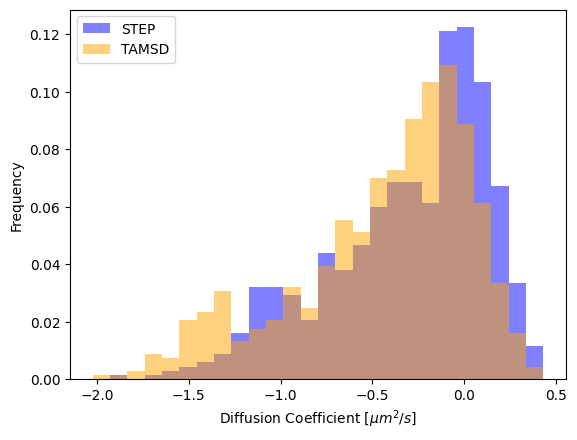

In [28]:
#Representation of Dif Coef of one dataset
mean_dif1 = [p.mean().numpy().item() for p in pred_d]
data1 = torch.cat(pred_d).numpy()
data1 = data1.mean()
data2 = np.array(tamsd_dif)
#Determine number of bins
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
width = np.diff(bin_edges)
plt.bar(bin_edges[:-1], relative_probs1, width=width, alpha=0.5, color='blue', label='STEP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=width, alpha=0.5, color='orange', label='TAMSD', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

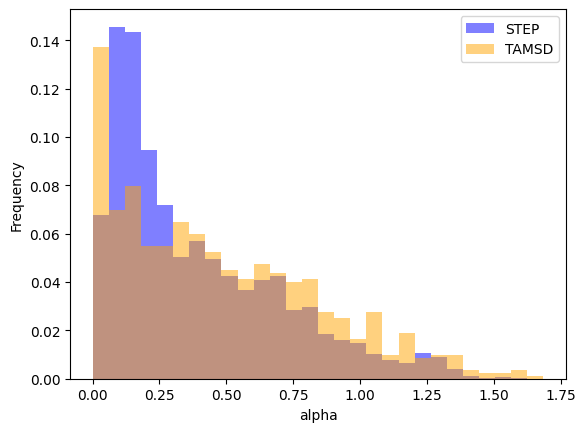

In [21]:
#Representation of alpha of one dataset
data1 = torch.cat(pred_a2).numpy()
data2 = np.array(tamsd_alpha2)
#Determine number of bins
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
width = np.diff(bin_edges)
plt.bar(bin_edges[:-1], relative_probs1, width=width, alpha=0.5, color='blue', label='STEP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=width, alpha=0.5, color='orange', label='TAMSD', align='edge')
plt.xlabel('alpha')
plt.ylabel('Frequency')
plt.legend()

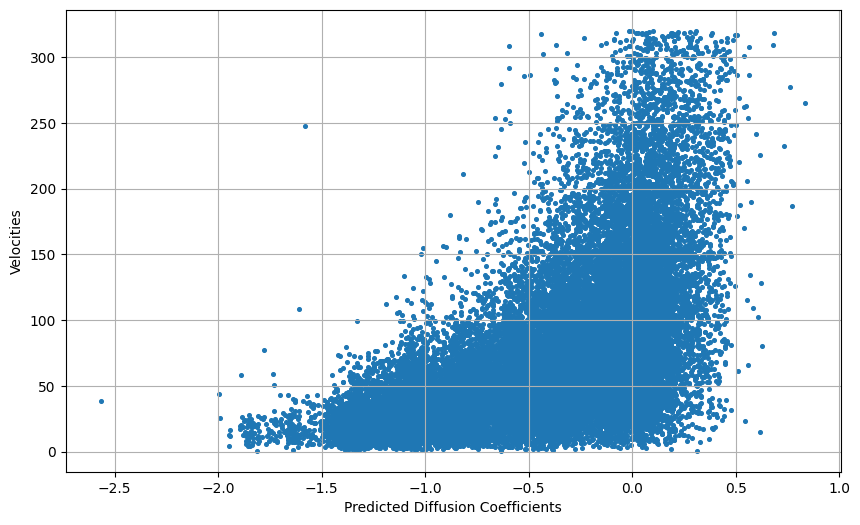

In [55]:
#Correlation predicted Dif. coef. and instantaneous velocity
velocities_np = np.concatenate([v.numpy().flatten() for v in velocities])
pred_d_np = np.concatenate([p.numpy().flatten() for p in pred_d])
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pred_d_np, velocities_np, alpha=1, s=7)  # alpha is to make dots semi-transparent
plt.ylabel('Velocities')
plt.xlabel('Predicted Diffusion Coefficients')
plt.grid(True)
plt.show()

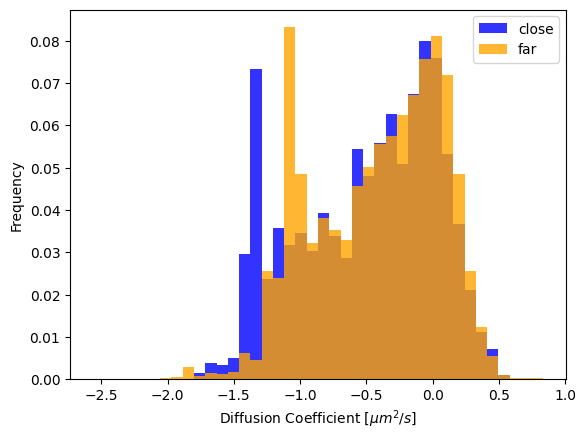

In [19]:
#Filtering of data by close and far, Dif. coef. 
data_close, data_far = [], []
for pred, c in zip(pred_d, all_close):
    # Duplicate the last value of preds to match the length of c
    last_pred_value = pred[-1]
    filled_values = torch.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred = torch.cat((pred, filled_values), dim=0)
    # Bolean indexing
    close_pred = pred[c < 5]
    far_pred = pred[c > 5]
    #Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data_close = torch.cat(data_close).numpy()
data_far = torch.cat(data_far).numpy()

#Representation close and far 1 dataset
#Determine number of bins
data1 = data_close
data2 = data_far
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [40]:
num_values = len(data_close) + len(data_far)
ratio_close = len(data_close)/num_values
ratio_far = len(data_far)/num_values
print(ratio_close, ratio_far)

0.3411597166435405 0.6588402833564595


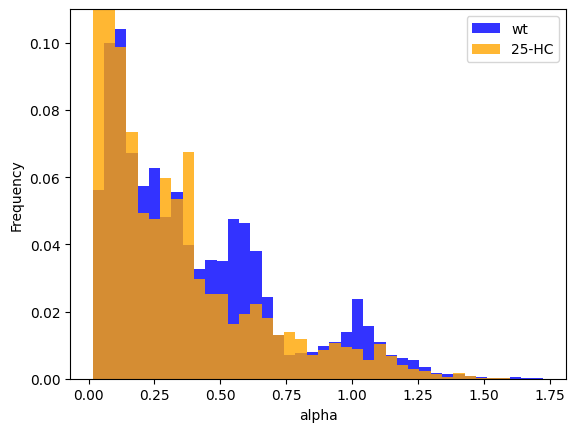

In [44]:
#Filtering of data by close and far, Dif. coef. 
data_close1, data_close2 = [], []
for pred1, pred2, c1, c2 in zip(pred_d, pred_d2, all_close, all_close2):
    # Duplicate the last value of preds to match the length of c
    last_pred_value = pred1[-1]
    filled_values = torch.full((len(c1) - len(pred1),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred1 = torch.cat((pred1, filled_values), dim=0)
    last_pred_value = pred2[-1]
    filled_values = torch.full((len(c2) - len(pred2),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred2 = torch.cat((pred2, filled_values), dim=0)
    # Bolean indexing
    close_pred1 = pred1[c1 <= 5]
    close_pred2 = pred2[c2 <= 5]
    #Append the data
    data_close1.append(close_pred1)
    data_close2.append(close_pred2)
data1 = torch.cat(data_close1).numpy()
data2 = torch.cat(data_close2).numpy()

#Representation close and far 1 dataset
#Determine number of bins
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylim(0, 0.11)
plt.ylabel('Frequency')
plt.legend()
plt.show()

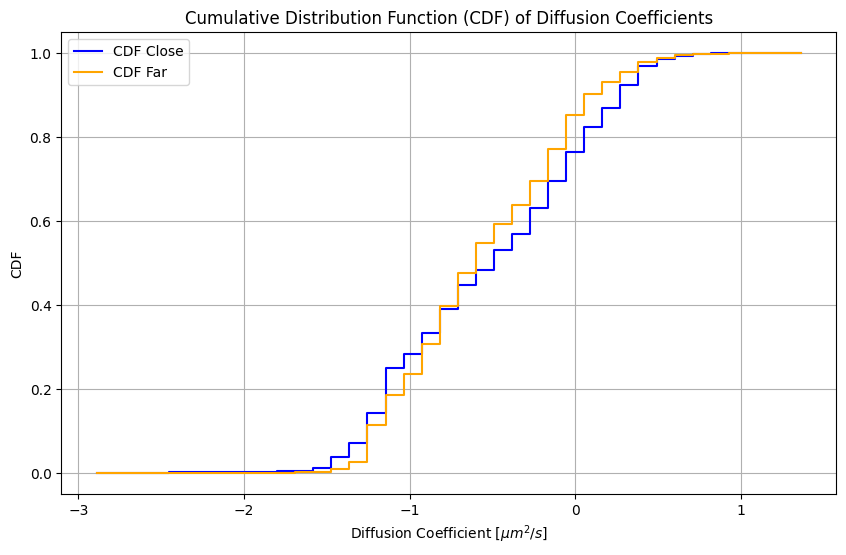

In [25]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

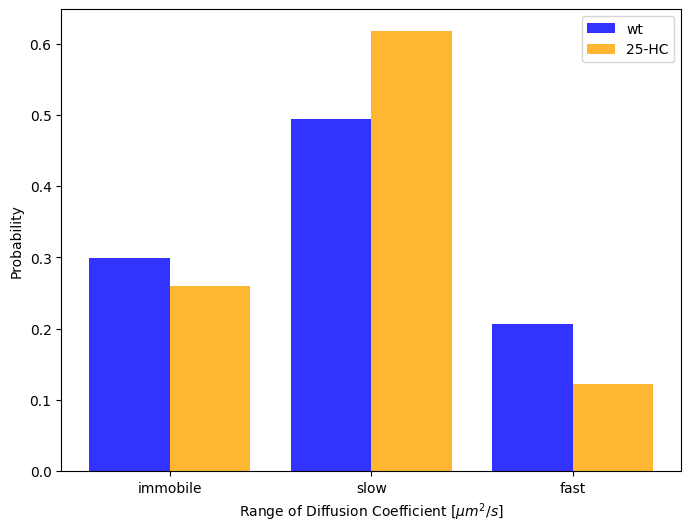

In [26]:
## Ploting bars
# Interpolation of probability values
points = [-1, 0]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, alpha=0.8, label='wt', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, alpha=0.8, label='25-HC', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

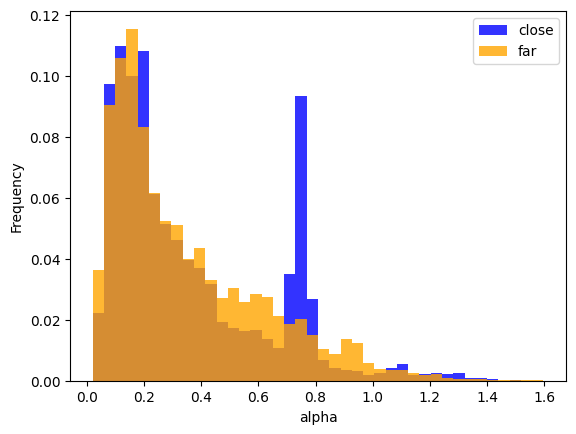

In [22]:
#Filtering of data by close and far, alpha
data_close, data_far = [], []
for pred, c in zip(pred_a, all_close):
    # Duplicate the last value of preds to match the length of c
    last_pred_value = pred[-1]
    filled_values = torch.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred = torch.cat((pred, filled_values), dim=0)
    # Bolean indexing
    c = torch.abs(c)
    close_pred = pred[c < 5]
    far_pred = pred[c > 5]
    #Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data_close = torch.cat(data_close).numpy()
data_far = torch.cat(data_far).numpy()

#Representation close and far 1 dataset
#Determine number of bins
data1 = data_close
data2 = data_far
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far', align='edge')
plt.xlabel('alpha')
plt.ylabel('Frequency')
plt.legend()

In [33]:
## Ridge plot for D vs. MCS

# Flatten the lists of tensors
all_close_flat = np.concatenate([c[:-1].numpy() for c in all_close]) #we eliminate the last value from each traj
all_close_flat *= 0.1567 #multiply by the pixel size (nm)
pred_d_flat = torch.cat(pred_d).numpy()

# Classify the predictions into groups
def classify_predictions(predictions):
    bins = [-2, -1, 0, 1]  # The edges of the bins for classification
    group_labels = ['immobile', 'slow', 'fast']
    group_indices = np.digitize(predictions, bins) - 1  # Get bin indices
    groups = [group_labels[i] if i < len(group_labels) else 'Unknown' for i in group_indices]
    return groups

# Assign each close1 value to a group based on pred_d
groups = classify_predictions(pred_d_flat)

# Create the DataFrame
df = pd.DataFrame({
    'Value': all_close_flat,
    'Group': groups
})
df['Group'] = pd.Categorical(df['Group'], categories=['immobile', 'slow', 'fast'], ordered=True)

In [34]:
from scipy.stats import gaussian_kde
import seaborn as sns

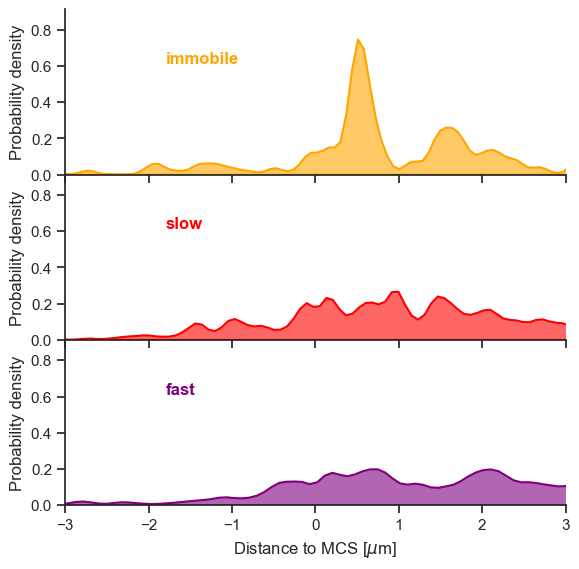

In [37]:
# Set up the matplotlib figure
custom_palette = {
    'immobile': 'orange', 
    'slow': 'red',    
    'fast': 'purple'  
}
sns.set(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the FacetGrid. 'row' should be the name of the DataFrame column that contains the group names.
g = sns.FacetGrid(df, row='Group', hue='Group', aspect=3, height=2,
                  palette=custom_palette)

# Binning
total_data_points = len(df['Value'])  # Total number of data points across all groups
num_bins = int(np.sqrt(total_data_points))

g.map(sns.kdeplot, 'Value', clip_on=True, fill=True, alpha=0.6, lw=1.5, bw_adjust=0.2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.2, .7, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axis titles and ticks
g.set_titles("")
g.set_xlabels('Distance to MCS [$\mu$m]')
g.set_ylabels('Probability density')

# Despine and show the plot
g.despine(bottom=False, left=False)  # Keep the left spine for the y-axis

# x-axis limits
for ax in g.axes.flat:
    ax.set_xlim(-3, 3)
    
plt.show()

In [33]:
## Ridge plot, classification by proximity to MCS
# Classify the predictions into groups
def classify_predictions(distance):
    bins = [-20, 0, 5, 20]  # The edges of the bins for classification
    group_labels = ['very close', 'close', 'far']
    group_indices = np.digitize(distance, bins) - 1  # Get bin indices
    groups = [group_labels[i] if i < len(group_labels) else 'Unknown' for i in group_indices]
    return groups

# Assign each close1 value to a group based on pred_d
groups = classify_predictions(all_close_flat)

# Create the DataFrame
df = pd.DataFrame({
    'Value': pred_d_flat,
    'Group': groups
})
df['Group'] = pd.Categorical(df['Group'], categories=['very close', 'close', 'far'], ordered=True)

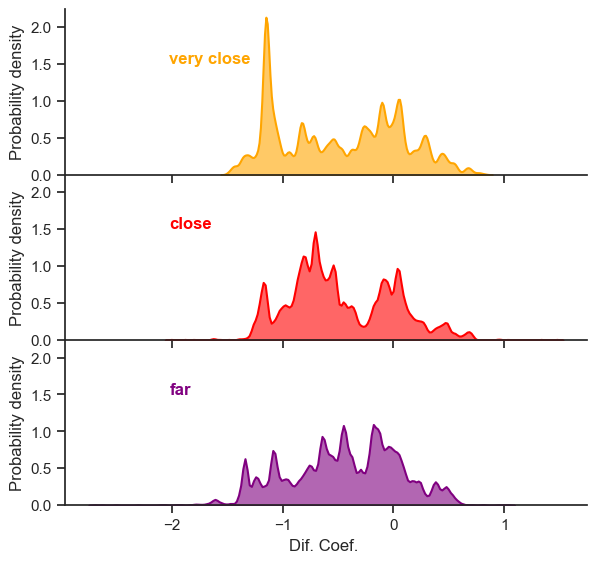

In [34]:
# Set up the matplotlib figure
custom_palette = {
    'very close': 'orange',
    'close': 'red',   
    'far': 'purple' 
}
sns.set(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the FacetGrid. 'row' should be the name of the DataFrame column that contains the group names.
g = sns.FacetGrid(df, row='Group', hue='Group', aspect=3, height=2,
                  palette=custom_palette)

# Binning
total_data_points = len(df['Value'])  # Total number of data points across all groups
num_bins = int(np.sqrt(total_data_points))

g.map(sns.kdeplot, 'Value', clip_on=True, fill=True, alpha=0.6, lw=1.5, bw_adjust=0.2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.2, .7, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axis titles and ticks
g.set_titles("")
g.set_xlabels('Dif. Coef. ')
g.set_ylabels('Probability density')

# Despine and show the plot
g.despine(bottom=False, left=False)  # Keep the left spine for the y-axis
plt.show()

In [119]:
print(len(all_close_flat))
print(len(pred_a_flat))

10789
10789


In [32]:
## Ridge plot for alpha vs. MCS

# Flatten the lists of tensors
all_close_flat = torch.cat(all_close).numpy()
pred_a_flat = torch.cat(pred_a).numpy()

# Classify the predictions into groups
def classify_predictions(distance):
    bins = [0, 2, 10, 30]  # The edges of the bins for classification
    group_labels = ['very close', 'close', 'far']
    group_indices = np.digitize(distance, bins) - 1  # Get bin indices
    groups = [group_labels[i] if i < len(group_labels) else 'Unknown' for i in group_indices]
    return groups

# Assign each close1 value to a group based on pred_d
groups = classify_predictions(all_close_flat)

# Create the DataFrame
df = pd.DataFrame({
    'Value': pred_a_flat,
    'Group': groups
})
df['Group'] = pd.Categorical(df['Group'], categories=['very close', 'close', 'far'], ordered=True)

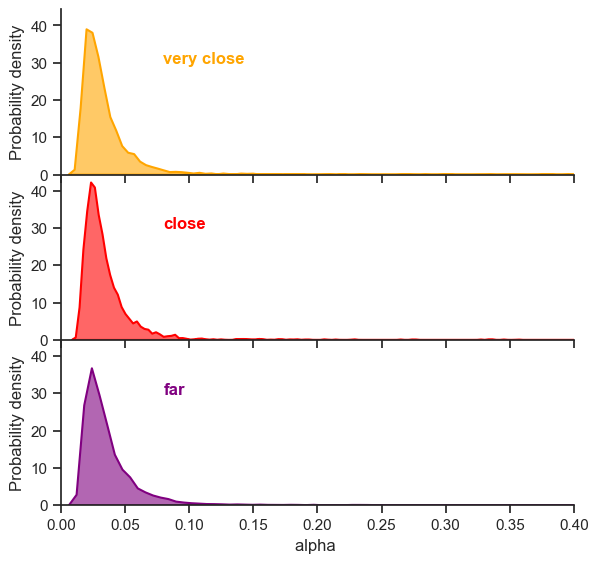

In [33]:
# Set up the matplotlib figure
custom_palette = {
    'very close': 'orange',  # Replace with the actual color you want for Group 1
    'close': 'red',     # Replace with the actual color you want for Group 2
    'far': 'purple'   # Replace with the actual color you want for Group 3
}
sns.set(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the FacetGrid. 'row' should be the name of the DataFrame column that contains the group names.
g = sns.FacetGrid(df, row='Group', hue='Group', aspect=3, height=2,
                  palette=custom_palette)

# Binning
total_data_points = len(df['Value'])  # Total number of data points across all groups
num_bins = int(np.sqrt(total_data_points))

g.map(sns.kdeplot, 'Value', clip_on=True, fill=True, alpha=0.6, lw=1.5, bw_adjust=0.2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.2, .7, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axis titles and ticks
g.set_titles("")
g.set_xlabels('alpha ')
g.set_ylabels('Probability density')

# Despine and show the plot
g.despine(bottom=False, left=False)  # Keep the left spine for the y-axis
for ax in g.axes.flat:
    ax.set_xlim(0, 0.4)
plt.show()

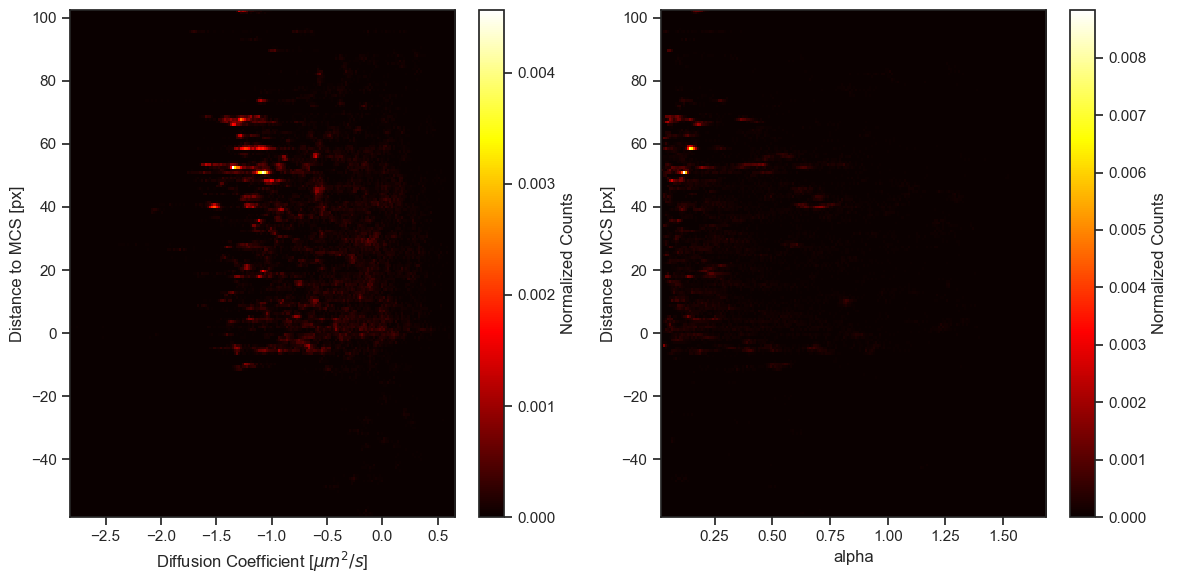

In [35]:
#Representation D and alpha vs. distance to MCS
# Process data
data1, data3 = [], []
for pred, pred2 in zip(pred_d2, pred_a2):
    # Duplicate the last value of pred
    last_pred_value1 = pred[-1].unsqueeze(0)
    pred = torch.cat((pred, last_pred_value1), dim=0)
    #Concatenate
    data1.append(pred)
    data3.append(pred2)
data1 =  torch.cat(data1).numpy()
data2 = torch.cat(all_close2).numpy()
data3 = torch.cat(data3).numpy()

# Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
chosen_bin_size = min(num_bins1, num_bins2, num_bins3)
data1_range = (min(data1), max(data1))
data2_range = (min(data2), max(data2))
data3_range = (min(data3), max(data3))
bins1 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data1_range[0], data1_range[1], chosen_bin_size + 1)]
bins2 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data3_range[0], data3_range[1], chosen_bin_size + 1)]

#Plot
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins1)
total_data_points = np.sum(hist_2d_1)
hist_2d_normalized1 = hist_2d_1 / total_data_points
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im1 = axs[0].imshow(hist_2d_normalized1, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[0].set_xlabel('Diffusion Coefficient [$\mu m^2/s$]')
axs[0].set_ylabel('Distance to MCS [px]')
axs[0].set_aspect('auto')
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical')
cbar1.set_label('Normalized Counts')
hist_2d_2, xedges, yedges = np.histogram2d(data2, data3, bins=bins2)
total_data_points = np.sum(hist_2d_2)
hist_2d_normalized2 = hist_2d_2 / total_data_points
im2 = axs[1].imshow(hist_2d_normalized2, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Distance to MCS [px]')
axs[1].set_aspect('auto')
#axs[1].set_ylim(-10,10)
#axs[0].set_ylim(-10,10)
cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical')
cbar2.set_label('Normalized Counts')
plt.tight_layout()

Text(0, 0.5, 'Mean Alpha')

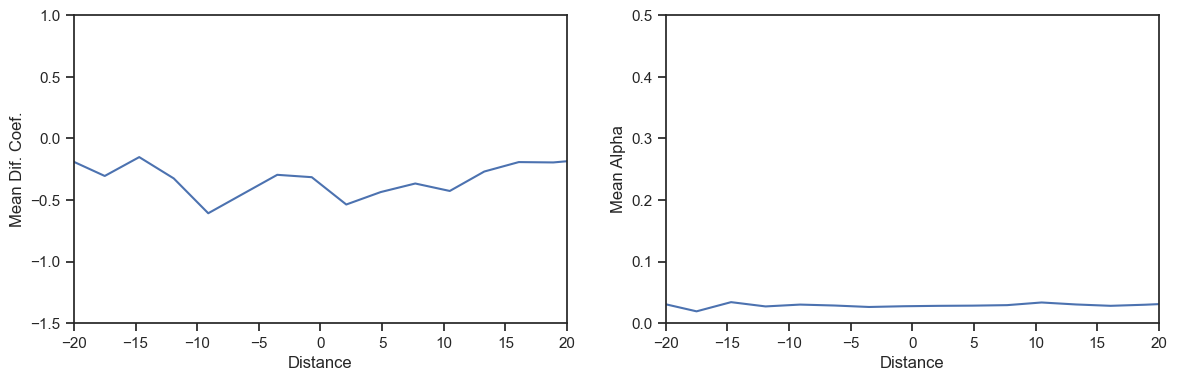

In [68]:
## Mean Dif and alpha for each distance
# Define bins for data2 values
num_bins = 60
bins = np.linspace(data2.min(), data2.max(), num_bins + 1)
bin_midpoints = (bins[:-1] + bins[1:]) / 2  # Calculate midpoints of bins for x-axis in plots


# Assign each data2 value to a bin
bin_indices = np.digitize(data2, bins)

# Create a DataFrame for easy calculation
df = pd.DataFrame({
    'Dif. coef.': data1,
    'alpha': data3,
    'distances': data2,
    'bin_index': bin_indices
})
df = df[df['bin_index'] < len(bins)] #remove last bin

# Calculate the mean prediction for each bin
mean_dif = df.groupby('bin_index')['Dif. coef.'].median()
mean_alpha = df.groupby('bin_index')['alpha'].median()

# Optional: Create a more readable output by associating bin ranges with the means
#bin_ranges = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
#mean_predictions_readable = mean_predictions_per_bin.rename(index=dict(zip(range(1, len(bins)), bin_ranges)))
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(bin_midpoints, mean_dif.values)
axes[0].set_ylim(-1.5, 1)
axes[0].set_xlim(-20, 20)
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Mean Dif. Coef.')
axes[1].plot(bin_midpoints, mean_alpha.values)
axes[1].set_ylim(0, 0.5)
axes[1].set_xlim(-20, 20)
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Mean Alpha')

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_29872\280341165.py:43: RuntimeWarning: invalid value encountered in divide
  hist_2d_normalized2 = hist_2d_2 / total_data_points


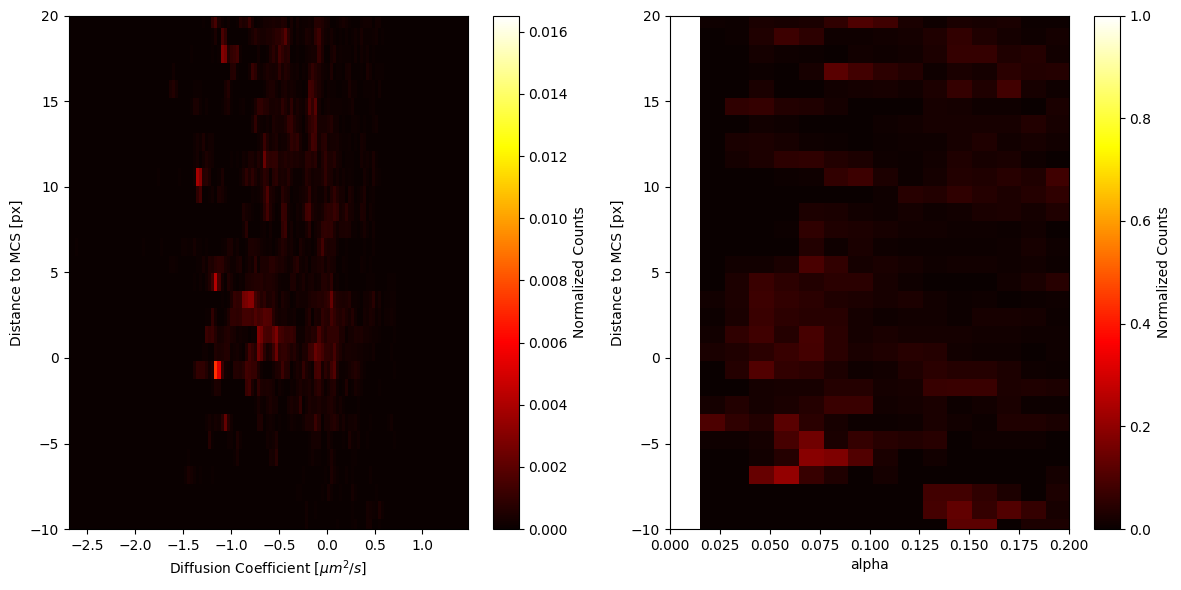

In [25]:
#Representation D and alpha vs. distance to MCS
# Process data
data1, data3 = [], []
for pred, pred2 in zip(pred_d2, pred_a2):
    # Duplicate the last value of pred
    last_pred_value1 = pred[-1].unsqueeze(0)
    pred = torch.cat((pred, last_pred_value1), dim=0)
    #Concatenate
    data1.append(pred)
    data3.append(pred2)
data1 =  torch.cat(data1).numpy()
data2 = torch.cat(all_close2).numpy()
data3 = torch.cat(data3).numpy()

# Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
chosen_bin_size = min(num_bins1, num_bins2, num_bins3)
data1_range = (min(data1), max(data1))
data2_range = (min(data2), max(data2))
data3_range = (min(data3), max(data3))
bins1 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data1_range[0], data1_range[1], chosen_bin_size + 1)]
bins2 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data3_range[0], data3_range[1], chosen_bin_size + 1)]

#Plot
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins1)
total_data_points = np.sum(hist_2d_1)
hist_2d_normalized1 = hist_2d_1 / total_data_points
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
im1 = axs[0].imshow(hist_2d_normalized1, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[0].set_xlabel('Diffusion Coefficient [$\mu m^2/s$]')
axs[0].set_ylabel('Distance to MCS [px]')
axs[0].set_aspect('auto')
axs[0].set_ylim(-10,20)
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical')
cbar1.set_label('Normalized Counts')
hist_2d_2, xedges, yedges = np.histogram2d(data2, data3, bins=bins2)
#total_data_points = np.sum(hist_2d_2)
total_data_points = hist_2d_2.sum(axis=1, keepdims=True) #total values per row
hist_2d_normalized2 = hist_2d_2 / total_data_points
im2 = axs[1].imshow(hist_2d_normalized2, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Distance to MCS [px]')
axs[1].set_aspect('auto')
axs[1].set_ylim(-10,20)
axs[1].set_xlim(0,0.2)
cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical')
cbar2.set_label('Normalized Counts')
plt.tight_layout()

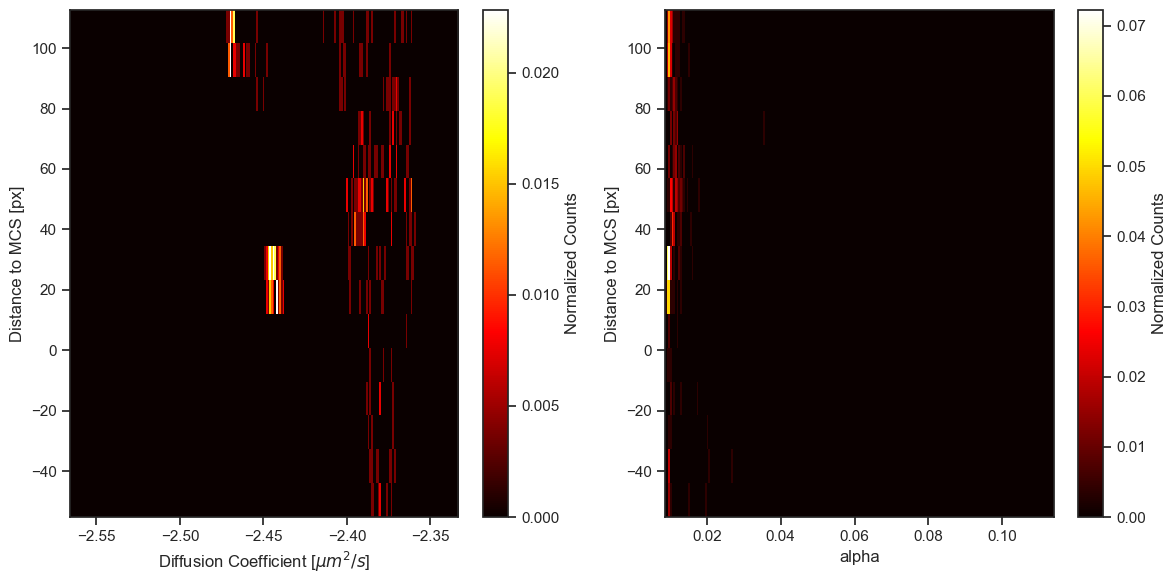

In [70]:
#Representation D and alpha vs. distance to MCS (subset)
# Process data
data1, data3 = [], []
for pred, pred2 in zip(pred_d, pred_a):
    # Duplicate the last value of pred
    last_pred_value1 = pred[-1].unsqueeze(0)
    pred = torch.cat((pred, last_pred_value1), dim=0)
    #Concatenate
    data1.append(pred)
    data3.append(pred2)
data1 =  torch.cat(data1).numpy()
data2 = torch.cat(all_close).numpy()
data3 = torch.cat(data3).numpy()

# Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
chosen_num = min(num_bins1, num_bins2, num_bins3)
data1_range = (min(data1), max(data1))
data2_range = (min(data2), max(data2))
data3_range = (min(data3), max(data3))
bins1 = [np.linspace(data2_range[0], data2_range[1], chosen_num + 1), 
        np.linspace(data1_range[0], data1_range[1], chosen_num + 1)]
bins2 = [np.linspace(data2_range[0], data2_range[1], chosen_num + 1), 
        np.linspace(data3_range[0], data3_range[1], chosen_num + 1)]

# Plot the subset with adjusted intensity
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins1)
hist_subset = hist_2d_1[0:15,:]
total_data_points = np.sum(hist_subset)
hist_subset = hist_subset / total_data_points
vmin_subset, vmax_subset = hist_subset.min(), hist_subset.max()
im1 = axs[0].imshow(hist_subset, cmap='hot', interpolation='nearest', origin='lower',
           extent=[yedges[0], yedges[16], xedges[0], xedges[-1]],
           vmin=vmin_subset, vmax=vmax_subset)
axs[0].set_xlabel('Diffusion Coefficient [$\mu m^2/s$]')
axs[0].set_ylabel('Distance to MCS [px]')
axs[0].set_aspect('auto')
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical')
cbar1.set_label('Normalized Counts')
hist_2d_2, xedges, yedges = np.histogram2d(data2, data3, bins=bins2)
hist_subset2 = hist_2d_2[0:15, :]
total_data_points = np.sum(hist_subset2)
hist_subset2 = hist_subset2 / total_data_points
vmin_subset, vmax_subset = hist_subset2.min(), hist_subset2.max()
im2 = axs[1].imshow(hist_subset2, cmap='hot', interpolation='nearest', origin='lower',
           extent=[yedges[0], yedges[16], xedges[0], xedges[-1]],
           vmin=vmin_subset, vmax=vmax_subset)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Distance to MCS [px]')
axs[1].set_aspect('auto')
cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical')
cbar2.set_label('Normalized Counts')
plt.tight_layout()

In [24]:
num_bins

122

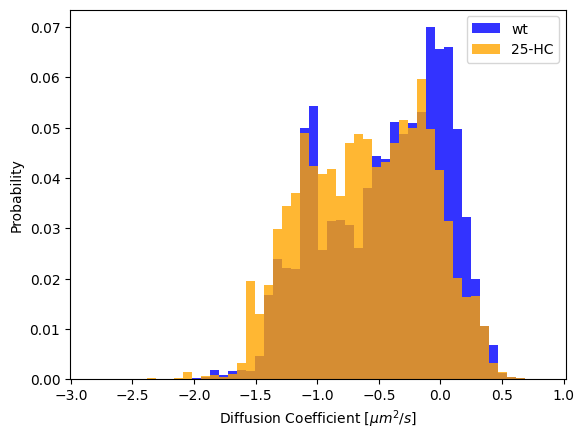

In [21]:
#Representation of both datasets
data1 = torch.cat(pred_d).numpy()
data2 = torch.cat(pred_d2).numpy()
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 50
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

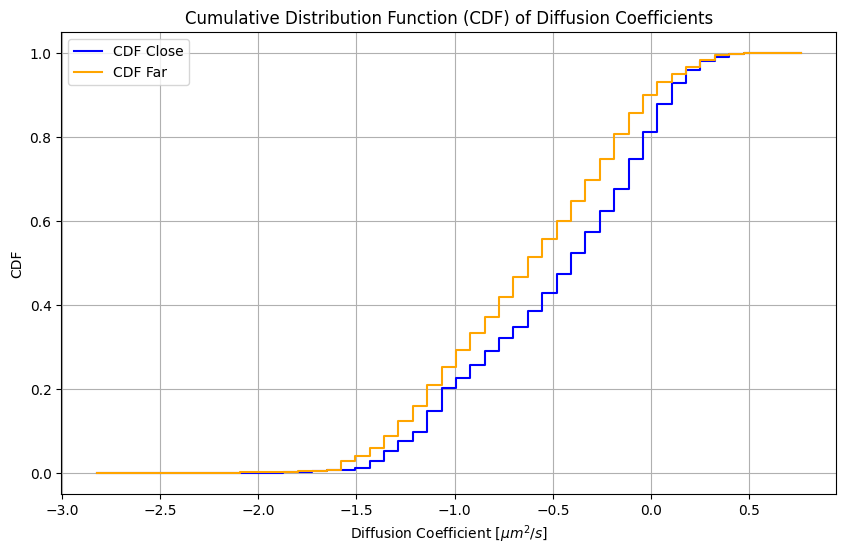

In [33]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Calculate the first derivative (approximate) of the CDFs
first_derivative_close = np.diff(cdf1) / np.diff(bin_edges[:-1])
first_derivative_far = np.diff(cdf2) / np.diff(bin_edges[:-1])

# Calculate the second derivative (approximate) of the CDFs
second_derivative_close = np.diff(first_derivative_close) / np.diff(bin_edges[:-2])
second_derivative_far = np.diff(first_derivative_far) / np.diff(bin_edges[:-2])

# Identifying significant changes
threshold = 5 #adjust based on your data
significant_changes_close = np.where(np.abs(second_derivative_close) > threshold)[0]
significant_changes_far = np.where(np.abs(second_derivative_far) > threshold)[0]

# Translate these indices back to your bin edges to find the ranges
significant_ranges_close = bin_edges[significant_changes_close]
significant_ranges_far = bin_edges[significant_changes_far]

print("Significant ranges for 'close':", significant_ranges_close)
print("Significant ranges for 'far':", significant_ranges_far)

Significant ranges for 'close': [-1.28619797 -1.13979697]
Significant ranges for 'far': []


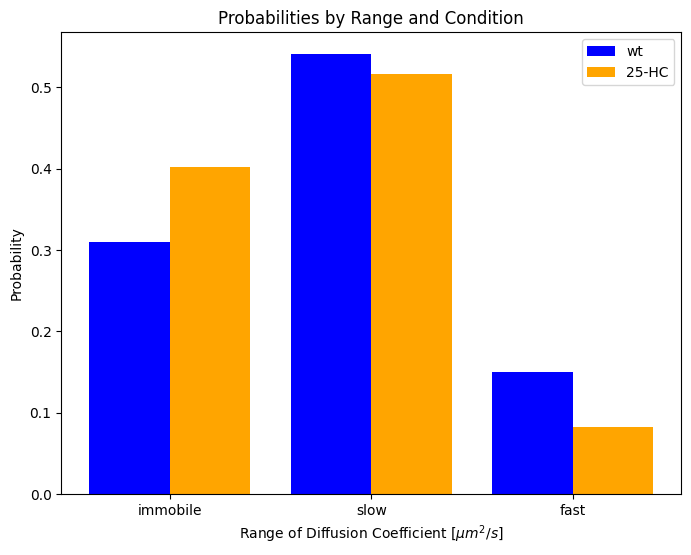

In [34]:
## PLoting bars
# Interpolation of probability values
points = [-0.8, 0]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, label='wt', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, label='25-HC', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient [$\mu m^2/s$]')
ax.set_ylabel('Probability')
ax.set_title('Probabilities by Range and Condition')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

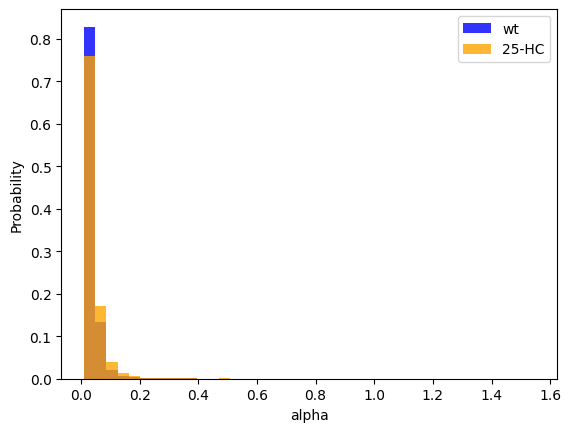

In [20]:
#Representation of both datasets
data1 = torch.cat(pred_a).numpy()
data2 = torch.cat(pred_a2).numpy()
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC', align='edge')
plt.xlabel('alpha')
plt.ylabel('Probability')
plt.legend()

In [22]:
## Calculating the mean value for te whole trajectory
mean_dif1 = [p.mean().numpy().item() for p in pred_d]
mean_dif2 = [p.mean().numpy().item() for p in pred_d2]
mean_alpha1 = [p.mean().numpy().item() for p in pred_a]
mean_alpha2 = [p.mean().numpy().item() for p in pred_a2]

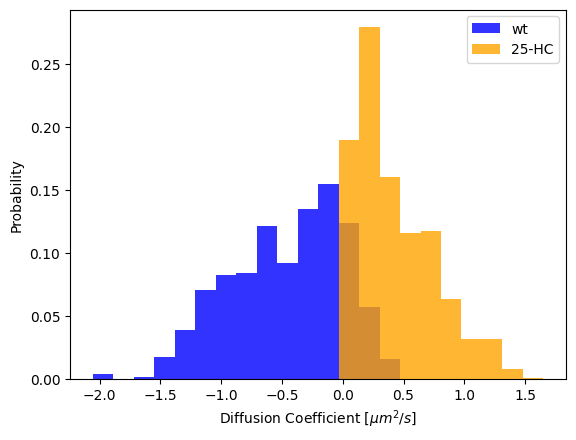

In [23]:
#Representation of both datasets
data1 = np.array(mean_dif1)
data1 = np.array(mean_dif2)
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

In [110]:
## Heat map STEP vs. TAMSD
# Process data
data1 = mean_dif1
data2 = tamsd_dif

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data2, data1, bins=[chosen_bin_size, chosen_bin_size])

# Normalize
total_data_points = np.sum(hist_2d)
hist_2d_normalized = hist_2d / total_data_points

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(-1.5,0.5,2), np.linspace(-1.5,0.5,2), color='blue')

NameError: name 'mean_dif1' is not defined

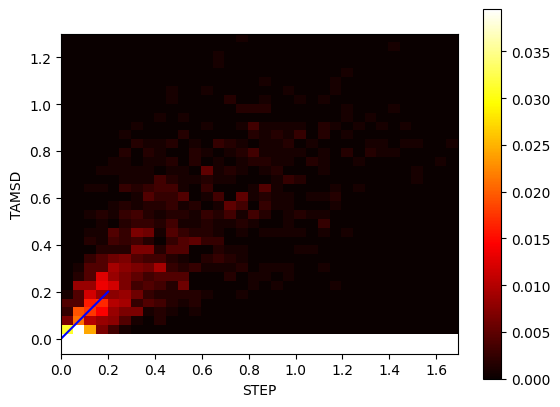

In [43]:
## Heat map STEP vs. TAMSD
# Process data
data1 = mean_alpha1
data2 = tamsd_alpha

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)

#chosen_bin_size = 20

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data2, data1, bins=[chosen_bin_size, chosen_bin_size])

# Normalize 
total_data_points = np.sum(hist_2d)
hist_2d_normalized = hist_2d / total_data_points

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(0,0.2,5), np.linspace(0,0.2,5), color='blue')

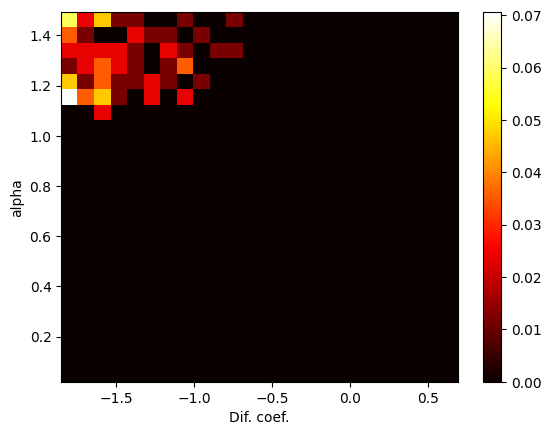

In [29]:
# Relationship diff. coef. and alpha
# Process data
data1 = np.array(mean_dif2)
data2 = np.array(mean_alpha2)

# Define the number of bins for each variable
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(num_bins1, num_bins2)
data1_range = (min(data1), max(data1))
data2_range = (min(data2), max(data2))
bins = [np.linspace(data1_range[0], data1_range[1], chosen_bin_size + 1), 
        np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1)]

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_1)
#total_data_points = hist_2d_1.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized = hist_2d_1 / total_data_points
hist_2d_normalized[np.isnan(hist_2d_normalized)] = 0 #replace NaNs with 0 (to avoid division by zero)

#Plot
#plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=0.8)
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('auto')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
#plt.ylim(0, data_range[1])
plt.colorbar()

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_22592\1199384597.py:23: RuntimeWarning: invalid value encountered in divide
  hist_2d_normalized1 = hist_2d_1 / total_data_points
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_22592\1199384597.py:31: RuntimeWarning: invalid value encountered in divide
  hist_2d_normalized2 = hist_2d_2 / total_data_points


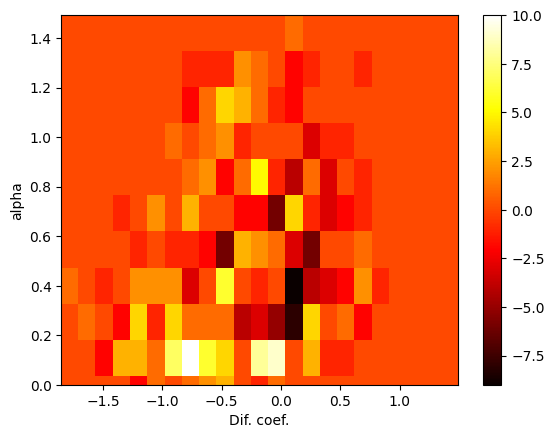

In [30]:
# Relationship diff. coef. and alpha
# Process data
data3 = np.array(mean_dif2)
data4 = np.array(mean_alpha2)
data1 = np.array(mean_dif1)
data2 = np.array(mean_alpha1)

# Define the number of bins for each variable
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
num_bins4 = int(np.sqrt(len(data4)))
chosen_bin_size = min(num_bins1, num_bins2, num_bins3, num_bins4)
data_range = [min(data1.min(), data2.min(), data3.min(), data4.min()), max(data1.max(), data2.max(), data3.max(), data4.max())]
bins = np.linspace(data_range[0], data_range[1], chosen_bin_size + 1)

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins)

# Normalization
#total_data_points = np.sum(hist_2d_1)
total_data_points = hist_2d_1.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized1 = hist_2d_1 / total_data_points

# Compute the 2D histogram
hist_2d_2, xedges, yedges = np.histogram2d(data4, data3, bins=bins)

# Normalization
#total_data_points = np.sum(hist_2d_2)
total_data_points = hist_2d_2.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized2 = hist_2d_2 / total_data_points

#Subtraction of the histograms
hist_2d_diff = hist_2d_2 - hist_2d_1

#Plot
plt.imshow(hist_2d_diff, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('auto')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
plt.ylim(0, data_range[1])
plt.colorbar()

# Prediction examples

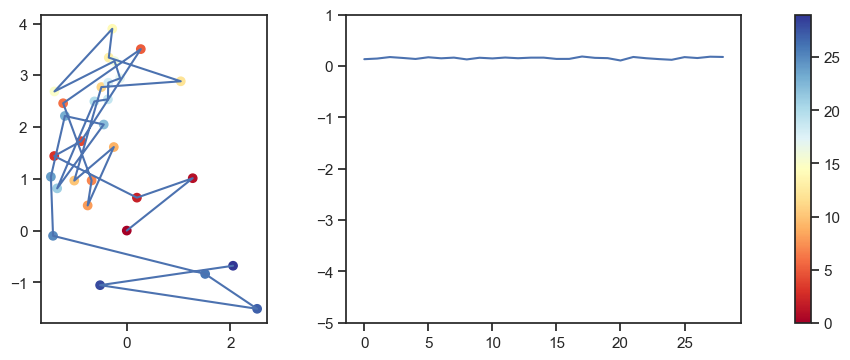

In [97]:
idx = 13
traj = all_trajectories[idx]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(traj[0], traj[1])
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = axes[0].scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1, ax=axes)
axes[1].plot(pred_d[idx])
axes[1].set_ylim(-5, 1)
axes[0].set_aspect('equal')

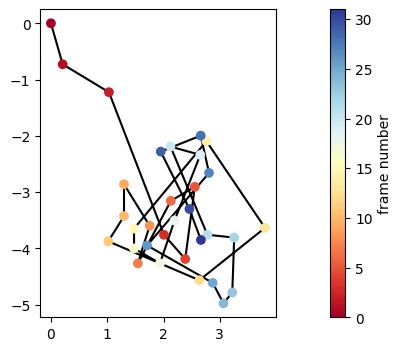

In [180]:
idx = 6
traj = all_trajectories2[idx]
plt.figure(figsize=(14, 4))
plt.plot(traj[0], traj[1], color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('frame number')
plt.gca().set_aspect('equal')

In [28]:
t_lag = [1, 2, 3, 4]
D_tamsd = (diffusion_coefficient_tamsd(tensor(traj).T, t_lag))
print(D_tamsd)

0.22330986559391022


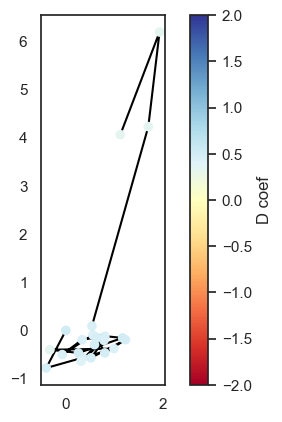

In [128]:
# Dif coef
idx = 32
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = pred_d2[idx][-1]
preds_idx_extended = np.append(pred_d2[idx], np.full(len(x) - len(pred_d2[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=-2, vmax=2)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('D coef')
plt.gca().set_aspect('equal')

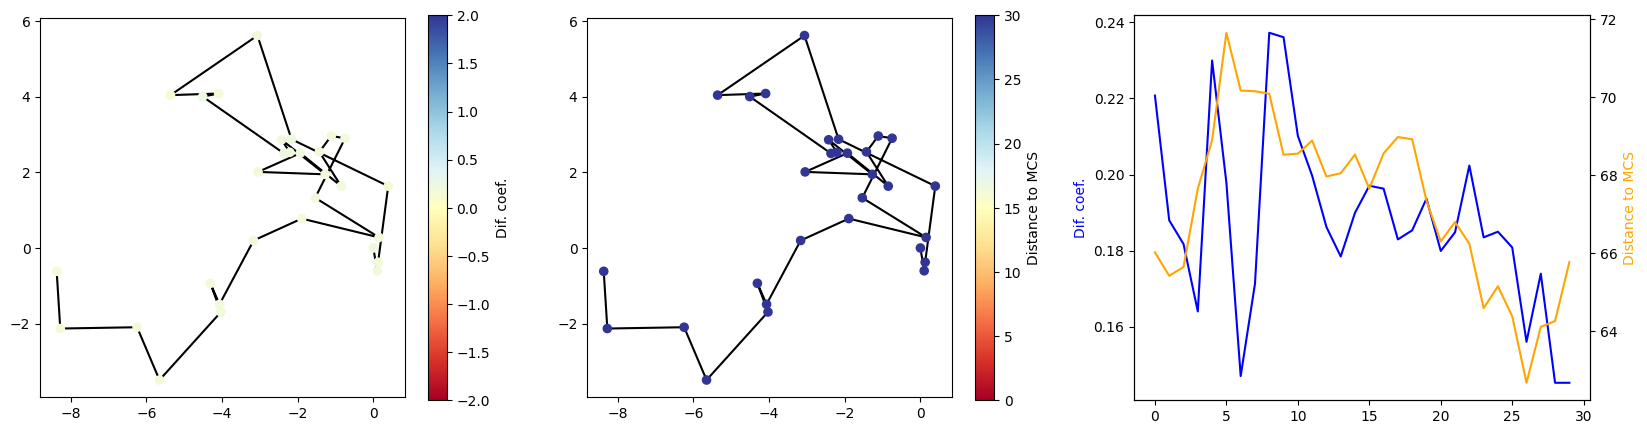

In [50]:
idx = 16
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
last_pred_value = pred_d[idx][-1] # Duplicate the last value of preds to match the length of x and y
preds_idx_extended = np.append(pred_d[idx], np.full(len(x) - len(pred_d[idx]), last_pred_value))
close = all_close[idx]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cm1 = matplotlib.colormaps['RdYlBu']
axes[0].plot(x, y, color='black', zorder=1)
axes[1].plot(x, y, color='black', zorder=1)
sc1 = axes[0].scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=-2, vmax=2)
sc2 = axes[1].scatter(x, y, c=close, s=35, cmap=cm1, zorder=2, vmin=0, vmax=30)
axes2_twin = axes[2].twinx()
axes[2].plot(preds_idx_extended, color='blue')
axes2_twin.plot(close, color='orange')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Dif. coef.')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Distance to MCS')
axes[2].set_ylabel('Dif. coef.', color='blue')
axes2_twin.set_ylabel('Distance to MCS', color='orange')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

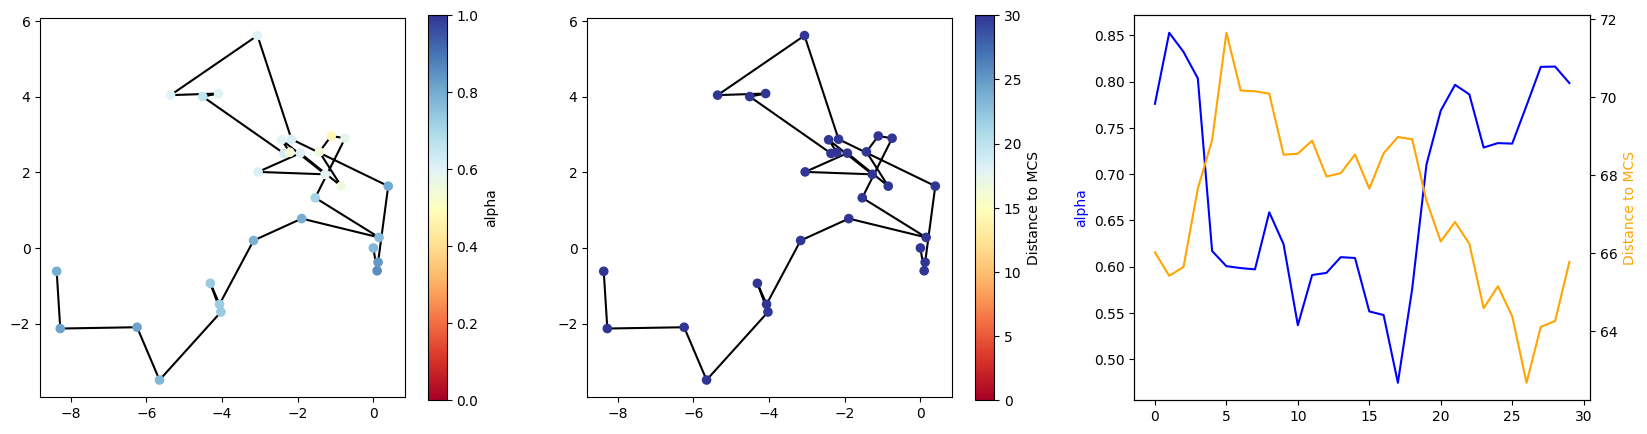

In [51]:
idx = 16
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
last_pred_value = pred_a[idx][-1] # Duplicate the last value of preds to match the length of x and y
preds_idx_extended = np.append(pred_a[idx], np.full(len(x) - len(pred_a[idx]), last_pred_value))
close = all_close[idx]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cm1 = matplotlib.colormaps['RdYlBu']
axes[0].plot(x, y, color='black', zorder=1)
axes[1].plot(x, y, color='black', zorder=1)
sc1 = axes[0].scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=0, vmax=1)
sc2 = axes[1].scatter(x, y, c=close, s=35, cmap=cm1, zorder=2, vmin=0, vmax=30)
axes2_twin = axes[2].twinx()
axes[2].plot(preds_idx_extended, color='blue')
axes2_twin.plot(close, color='orange')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('alpha')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Distance to MCS')
axes[2].set_ylabel('alpha', color='blue')
axes2_twin.set_ylabel('Distance to MCS', color='orange')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

In [53]:
# Alpha
idx = 6
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = pred_a2[idx][-1]
preds_idx_extended = np.append(pred_a2[idx], np.full(len(x) - len(pred_a2[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=0, vmax=2)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('alpha')
plt.gca().set_aspect('equal')

ValueError: negative dimensions are not allowed

# Trajectory segmentation

Segmentation only by diffusion coefficient: 

In [23]:
def find_segments(pred, traj, pen=1, **kwargs):
    import ruptures as rpt
    alg = rpt.KernelCPD(**kwargs).fit(pred) # Only changes in D
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, alphas_tamsd, angles = [], [], [], [], []
    new_d = np.ones_like(pred)
    d_tamsd = np.ones_like(pred)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        D_seg = pred[i:j].mean()
        new_d[i:j] *= D_seg
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
        a = parameters[1]
        d_tamsd[i:j] *= D_tamsd
        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            segments.append(segment)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)
        alphas_tamsd.append(a)

    return new_d, d_tamsd, segments, Ds, Ds_tamsd, alphas_tamsd, angles

In [54]:
seg_ds, seg_ds_tamsd, seg_angs, trajs, new_Dif, new_tamsd, seg_alphas_tamsd = [], [], [], [], [], [], []
for traj, pred in tqdm(zip(trajectories2, pred_d2)):
    pred1 = pred.numpy()
    pred1 = pred1.T
    x, y = traj[0], traj[1]
    traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
    out = find_segments(pred1, traj, min_size=6, pen=0.5) # previously min_size=10, pen=0.1
    new_d, d_tamsd, segments, d_seg, dtamsd_seg, alphas_tamsd, angs = out
    new_Dif.append(new_d)
    new_tamsd.append(d_tamsd)
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_angs.append(angs)
    trajs.append(segments)
seg_ds = np.concatenate(seg_ds)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_alphas_tamsd.append(alphas_tamsd)
seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]

0it [00:00, ?it/s]

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\872114572.py:6: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\212549062.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


Text(0.5, 0, 'Frame number')

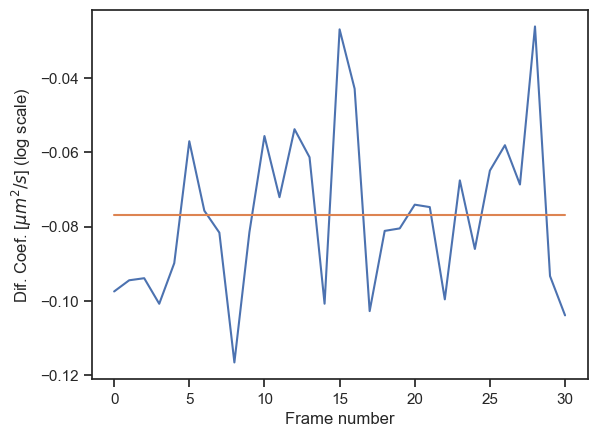

In [69]:
idx = 6
plt.plot(pred_d2[idx])
plt.plot(new_Dif[idx])
plt.ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)')
plt.xlabel('Frame number')

In [57]:
pred1 = pred_d2[32].numpy()
pred1 = pred1.T
x, y = traj[0], traj[1]
traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
out = find_segments(pred1, traj, min_size=4, pen=2) # previously min_size=10, pen=0.1
new_d, d_tamsd, segments, d_seg, dtamsd_seg, alphas_tamsd, angs = out
print(d_seg, dtamsd_seg)

[0.4546155] [0.110582259373802]


C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\872114572.py:6: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\872114572.py:7: RuntimeWarning: invalid value encountered in divide
  unit_vector_2 = vector_2 / np.linalg.norm(vector_2)


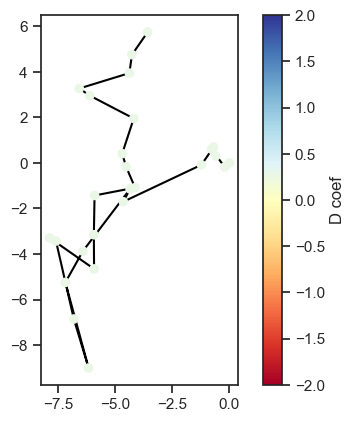

In [60]:
# Select trajectory
idx = 50
traj = trajectories2[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = new_Dif[idx][-1]
preds_idx_extended = np.append(new_Dif[idx], np.full(len(x) - len(new_Dif[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=-2, vmax=2)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('D coef')
plt.gca().set_aspect('equal')

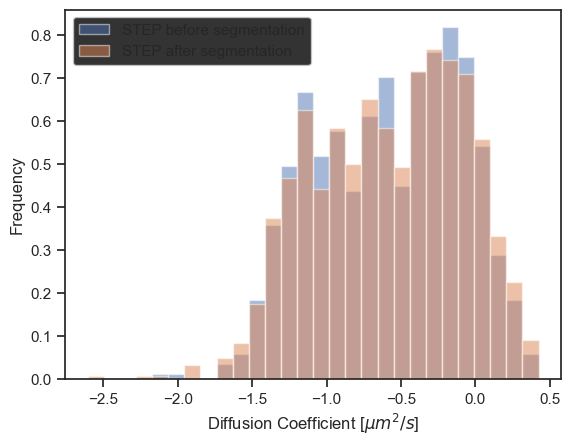

In [82]:
# Representation
data1 = np.array(mean_dif2)
data2 = np.array(seg_ds)
data3 = np.array(tamsd_dif)
data4 = np.array(seg_ds_tamsd)
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
num_bins4 = int(np.sqrt(len(data4)))
num_bins = min(num_bins1, num_bins2, num_bins3, num_bins4)
min_value = min(data1.min(), data2.min(), data3.min(), data4.min())
max_value = max(data1.max(), data2.max(), data3.max(), data4.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
#Compute histograms
hist1, _ = np.histogram(data1, bins=bin_edges, density=True)
hist2, _ = np.histogram(data2, bins=bin_edges, density=True)
hist3, _ = np.histogram(data3, bins=bin_edges, density=True)
hist4, _ = np.histogram(data4, bins=bin_edges, density=True)
# Plot the histograms
plt.bar(bin_edges[:-1], hist1, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='STEP before segmentation')
plt.bar(bin_edges[:-1], hist2, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='STEP after segmentation')
#plt.bar(bin_edges[:-1], hist3, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='TAMSD before sementation')
#plt.bar(bin_edges[:-1], hist4, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='TAMSD after sementation')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [81]:
print(len(mean_dif2),len(tamsd_dif),len(seg_ds))

801 1189 1107


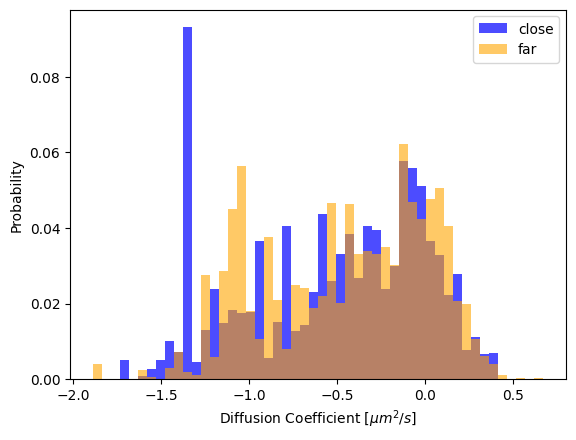

In [100]:
#Filtering of data by close and far, Dif. coef. 
data_close, data_far = [], []
for pred, c in zip(new_Dif, all_close):
    # Duplicate the last value of pred to match the length of c
    last_pred_value = pred[-1]
    filled_values = np.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype)
    pred = np.concatenate((pred, filled_values), axis=0)
    # Boolean indexing
    close_pred = pred[c <= 5]
    far_pred = pred[c > 5]
    # Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data1 = np.concatenate(data_close)
data2 = np.concatenate(data_far)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
num_bins = 50
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.7, color='blue', label='close')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='orange', label='far')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

In [101]:
print(len(data1), len(data2))

9343 18043


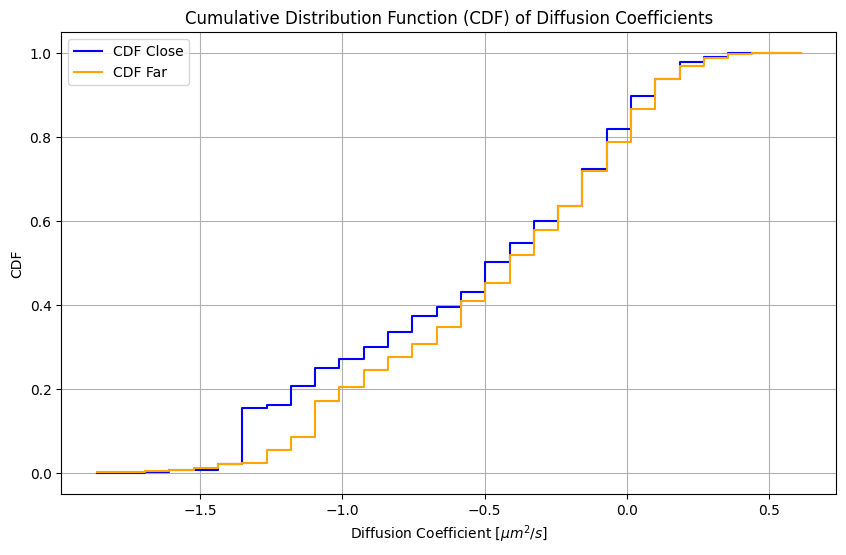

In [49]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Calculate the first derivative (approximate) of the CDFs
first_derivative_close = np.diff(cdf1) / np.diff(bin_edges[:-1])
first_derivative_far = np.diff(cdf2) / np.diff(bin_edges[:-1])

# Calculate the second derivative (approximate) of the CDFs
second_derivative_close = np.diff(first_derivative_close) / np.diff(bin_edges[:-2])
second_derivative_far = np.diff(first_derivative_far) / np.diff(bin_edges[:-2])

# Identifying significant changes
threshold = 7 #adjust based on your data
significant_changes_close = np.where(np.abs(second_derivative_close) > threshold)[0]
significant_changes_far = np.where(np.abs(second_derivative_far) > threshold)[0]

# Translate these indices back to your bin edges to find the ranges
significant_ranges_close = bin_edges[significant_changes_close]
significant_ranges_far = bin_edges[significant_changes_far]

print("Significant ranges for 'close':", significant_ranges_close)
print("Significant ranges for 'far':", significant_ranges_far)

Significant ranges for 'close': [-1.52251824 -1.43717922 -0.32777196]
Significant ranges for 'far': [-1.26650118]


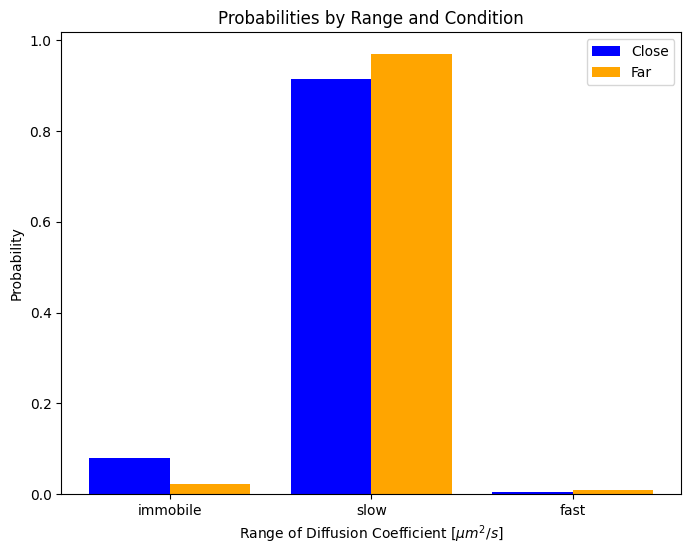

In [73]:
## Ploting bars
# Interpolation of probability values
points = [-1.4, 0.3]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, label='Close', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, label='Far', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient [$\mu m^2/s$]')
ax.set_ylabel('Probability')
ax.set_title('Probabilities by Range and Condition')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

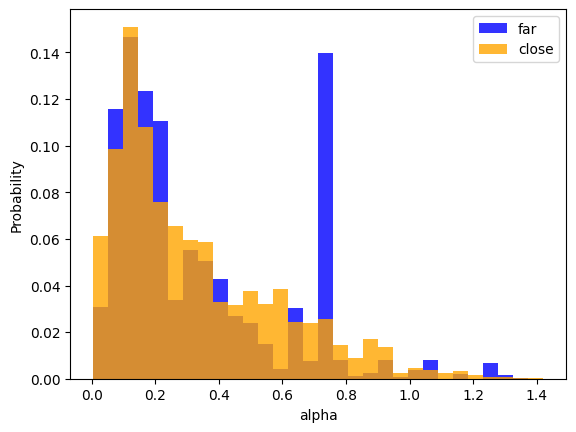

In [44]:
#Filtering of data by close and far, alpha 
data_close, data_far = [], []
for pred, c in zip(new_alpha, all_close):
    # Duplicate the last value of pred to match the length of c
    last_pred_value = pred[-1]
    filled_values = np.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype)
    pred = np.concatenate((pred, filled_values), axis=0)
    # Boolean indexing
    close_pred = pred[c <= 5]
    far_pred = pred[c > 5]
    # Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data1 = np.concatenate(data_close)
data2 = np.concatenate(data_far)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 30
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far')
plt.xlabel('alpha')
plt.ylabel('Probability')
plt.legend()

Segmentation by both dif coef and alpha

In [26]:
def find_segments2(pred1, pred2, traj, close, pen=1, **kwargs):
    import ruptures as rpt
    pred = np.column_stack((pred1, pred2)) #concatenate pred_d and pred_alpha
    alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, alphas, alphas_tamsd, position = [], [], [], [], [], []
    new_d, new_a = np.ones_like(pred1), np.ones_like(pred2)
    d_tamsd = np.ones_like(pred1)
    for i, j in zip(cps[:-1], cps[1:]): #iterate over each segment defined by consecutive cps
        segment = traj[:, i:j]
        alpha_seg, D_seg, loc = pred2[i:j].mean(), pred1[i:j].mean(), close[i:j].mean()
        new_d[i:j] *= D_seg
        new_a[i:j] *= alpha_seg
        #Fit the MSD curve
        x, y = traj[0], traj[1]
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
        a = parameters[1]
        d_tamsd[i:j] *= D_tamsd
        segments.append(segment)
        alphas.append(alpha_seg)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)
        alphas_tamsd.append(a)
        position.append(loc)
    return new_d, d_tamsd, new_a, segments, Ds, Ds_tamsd, alphas, alphas_tamsd, position

In [49]:
seg_ds, seg_ds_tamsd, seg_angs, seg_alphas, trajs, new_Dif, new_alpha, new_tamsd, seg_alphas_tamsd, jumps_dif, jumps_alpha, location, cps_location = [], [], [], [], [], [], [], [], [], [], [], [], []
for traj, pred1, pred2, close in tqdm(zip(all_trajectories2, pred_d2, pred_a2, all_close2)):
    pred1 = pred1.numpy()
    pred2 = pred2.numpy()[:-1] #remove last value
    traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
    out = find_segments2(pred1, pred2, traj, close, min_size=4, pen=0.5) # previously min_size=10, pen=0.1
    new_d, d_tamsd, new_a, segments, d_seg, dtamsd_seg, alphas, alphas_tamsd, position = out
    new_Dif.append(new_d)
    new_alpha.append(new_a)
    new_tamsd.append(d_tamsd)
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_alphas_tamsd.append(alphas_tamsd)
    trajs.append(segments)
    seg_alphas.append(alphas)
    location.append(position)
    #Calculate changepoint diff and location
    diff_d = np.diff(new_d)  # Successive differences in new_d
    diff_a = np.diff(new_a)  # Successive differences in new_a
    jump_indices_d = np.where(np.abs(diff_d) > 0)[0]  # Indices of jumps in new_d
    jump_indices_a = np.where(np.abs(diff_a) > 0)[0]  # Indices of jumps in new_a
    jump_d = diff_d[jump_indices_d]
    jump_a = diff_a[jump_indices_d]
    cps_loc = close[jump_indices_d + 1]
    cps_location.append(cps_loc)
    jumps_dif.append(jump_d)
    jumps_alpha.append(jump_a)

seg_ds = np.concatenate(seg_ds)
location = np.concatenate(location)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_alphas_tamsd = np.concatenate(seg_alphas_tamsd)
seg_alphas = np.concatenate(seg_alphas)
seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]
jumps_dif = np.concatenate(jumps_dif)
jumps_alpha = np.concatenate(jumps_alpha)
cps_location = np.concatenate(cps_location)

0it [00:00, ?it/s]

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_21804\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_21804\872114572.py:22: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x)


In [90]:
print(len(cps_location), len(seg_ds), len(jumps_alpha))

226 912 226


Text(0, 0.5, 'Distance to MCS')

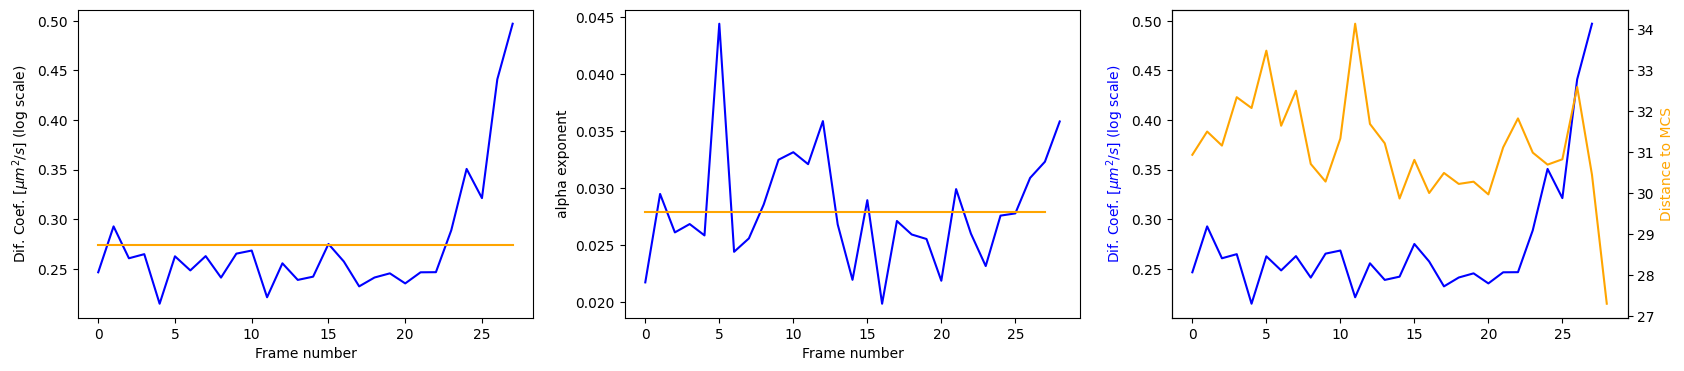

In [34]:
idx = 1
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
axes[0].plot(pred_d[idx], color='blue')
axes[0].plot(new_Dif[idx], color='orange')
axes[0].set_ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)')
axes[0].set_xlabel('Frame number')
axes[1].plot(pred_a[idx], color='blue')
axes[1].plot(new_alpha[idx], color='orange')
axes[1].set_ylabel('alpha exponent')
axes[1].set_xlabel('Frame number')
axes2_twin = axes[2].twinx()
axes[2].plot(pred_d[idx], color='blue')
axes2_twin.plot(all_close[idx], color='orange')
axes[2].set_ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)', color='blue')
axes2_twin.set_ylabel('Distance to MCS', color='orange')

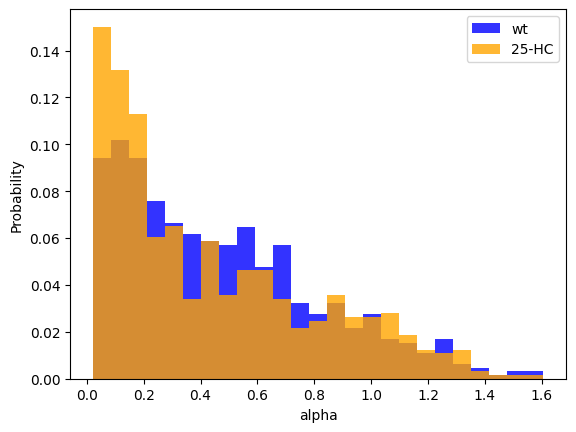

In [23]:
#Representation of both datasets
data1 = np.array(seg_alphas)
data2 = np.array(seg_alphas2)
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC', align='edge')
plt.xlabel('alpha')
plt.ylabel('Probability')
plt.legend()

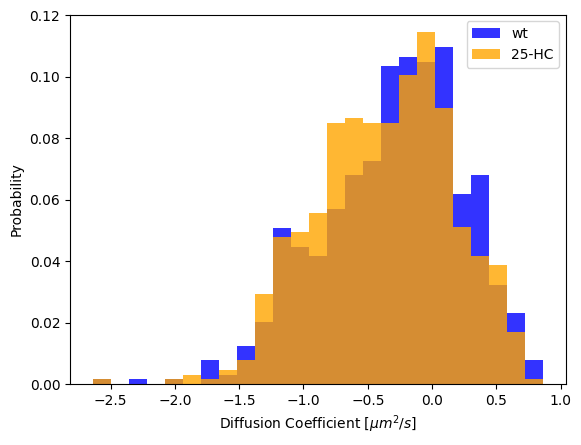

In [24]:
#Representation of both datasets
data1 = np.array(seg_ds)
data2 = np.array(seg_ds2)
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

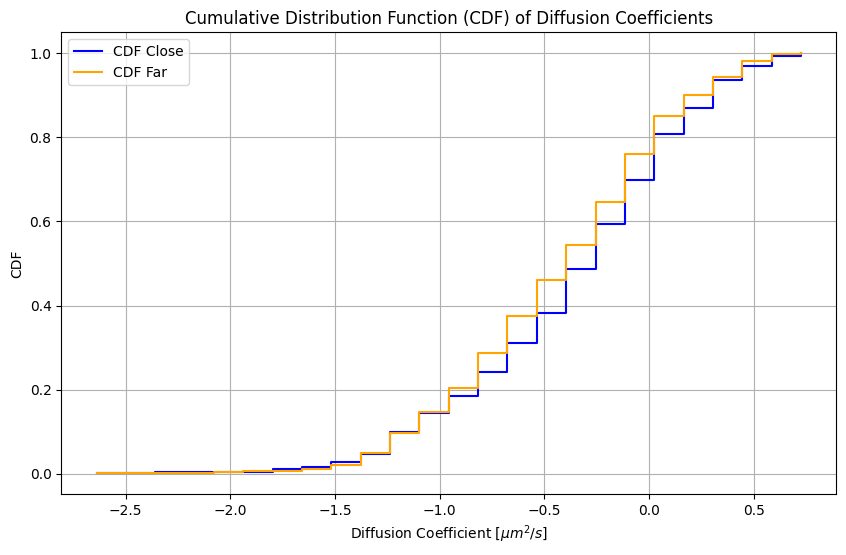

In [25]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Calculate the first derivative (approximate) of the CDFs
first_derivative_close = np.diff(cdf1) / np.diff(bin_edges[:-1])
first_derivative_far = np.diff(cdf2) / np.diff(bin_edges[:-1])

# Calculate the second derivative (approximate) of the CDFs
second_derivative_close = np.diff(first_derivative_close) / np.diff(bin_edges[:-2])
second_derivative_far = np.diff(first_derivative_far) / np.diff(bin_edges[:-2])

# Identifying significant changes
threshold = 1 #adjust based on the data
significant_changes_close = np.where(np.abs(second_derivative_close) > threshold)[0]
significant_changes_far = np.where(np.abs(second_derivative_far) > threshold)[0]

# Translate these indices back to your bin edges to find the ranges
significant_ranges_close = bin_edges[significant_changes_close]
significant_ranges_far = bin_edges[significant_changes_far]

print("Significant ranges for 'close':", significant_ranges_close)
print("Significant ranges for 'far':", significant_ranges_far)

Significant ranges for 'close': [-1.51789948 -0.67670291 -0.1159052   0.16449366]
Significant ranges for 'far': [-1.6580989  -1.09730119 -0.25610463 -0.1159052   0.30469308]


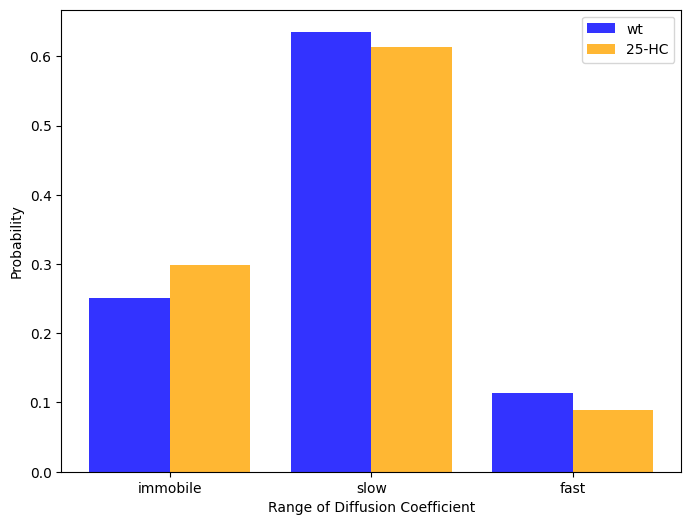

In [27]:
## Ploting bars
# Interpolation of probability values
points = [-0.8, 0.2]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, alpha=0.8, label='wt', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, alpha=0.8, label='25-HC', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [97]:
#Filtering of data by close and far, alpha 
data_close1, data_close2 = [], []
for pred1, pred2, c1, c2 in zip(seg_ds, seg_ds2, location, location2):
    # Boolean indexing
    close_pred1 = pred1[c1 <= 5]
    close_pred2 = pred2[c2 <= 5]
    # Append the data
    data_close1.append(close_pred1)
    data_close2.append(close_pred2)
data1 = np.concatenate(data_close1)
data2 = np.concatenate(data_close2)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

NameError: name 'seg_ds2' is not defined

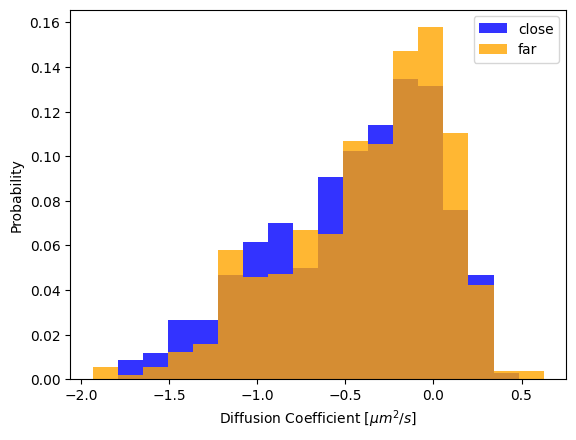

In [98]:
#Filtering of data by close and far, alpha 
data_close, data_far = [], []
for pred, c in zip(seg_ds, location):
    # Boolean indexing
    close_pred = pred[c <= 5]
    far_pred = pred[c > 5]
    # Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data1 = np.concatenate(data_close)
data2 = np.concatenate(data_far)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

In [99]:
print(len(data1), len(data2))

342 570


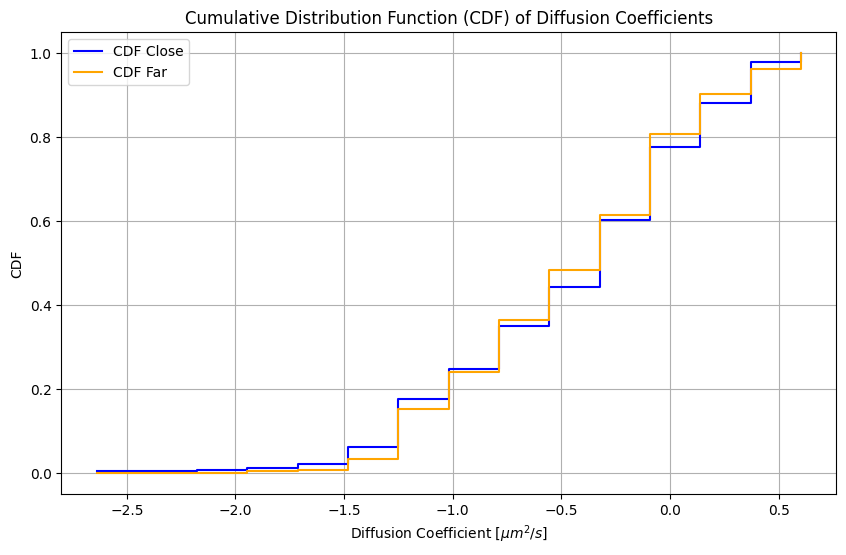

In [35]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

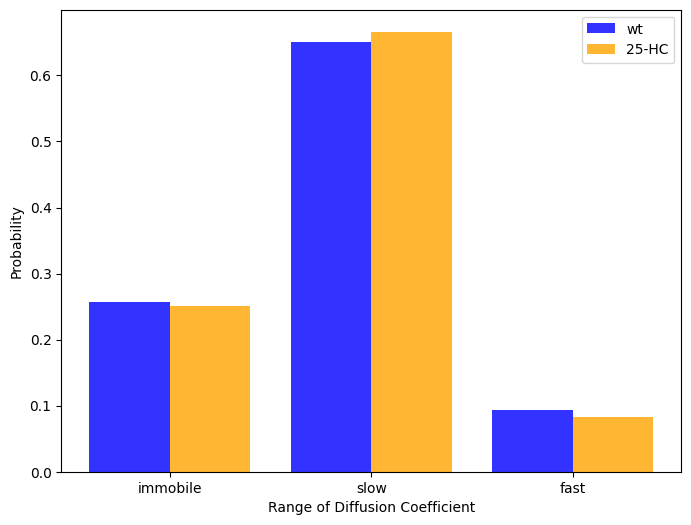

In [40]:
## Ploting bars
# Interpolation of probability values
points = [-0.8, 0.2]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, alpha=0.8, label='wt', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, alpha=0.8, label='25-HC', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

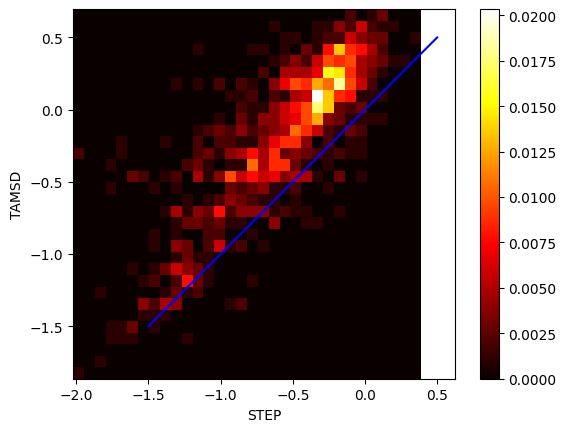

In [112]:
## Heat map STEP vs. TAMSD
# Process data
data1 = seg_ds
data2 = seg_ds_tamsd

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data2, data1, bins=[chosen_bin_size, chosen_bin_size])

# Normalize 
total_data_points = np.sum(hist_2d)
hist_2d_normalized = hist_2d / total_data_points

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(-1.5,0.5,2), np.linspace(-1.5,0.5,2), color='blue')

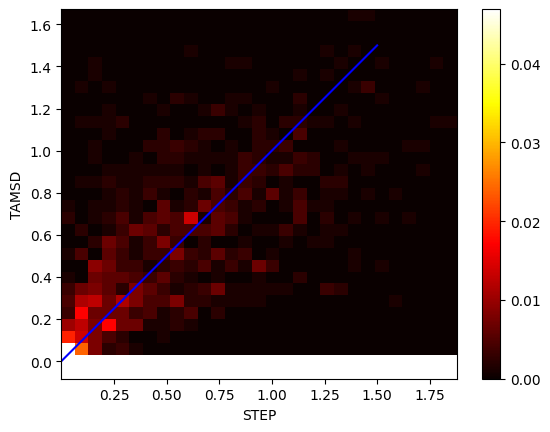

In [37]:
## Heat map STEP vs. TAMSD for alpha
# Process data
data1 = seg_alphas
data2 = seg_alphas_tamsd

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)

#chosen_bin_size = 20

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data2, data1, bins=[chosen_bin_size, chosen_bin_size])

# Normalize 
total_data_points = np.sum(hist_2d)
hist_2d_normalized = hist_2d / total_data_points

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(0,1.5,2), np.linspace(0,1.5,2), color='blue')

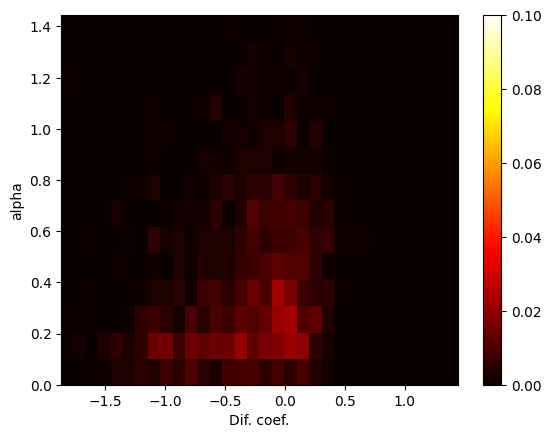

In [195]:
# Relationship diff. coef. and alpha
# Process data
data1 = seg_ds
data2 = seg_alphas

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)
data_range = [min(data1.min(), data2.min()), max(data1.max(), data2.max())]
bins = np.linspace(data_range[0], data_range[1], chosen_bin_size + 1)

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_1)
hist_2d_normalized1 = hist_2d_1 / total_data_points

#Plot
plt.imshow(hist_2d_normalized1, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=0.1)
plt.gca().set_aspect('auto')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
plt.ylim(0, data_range[1])
plt.colorbar()

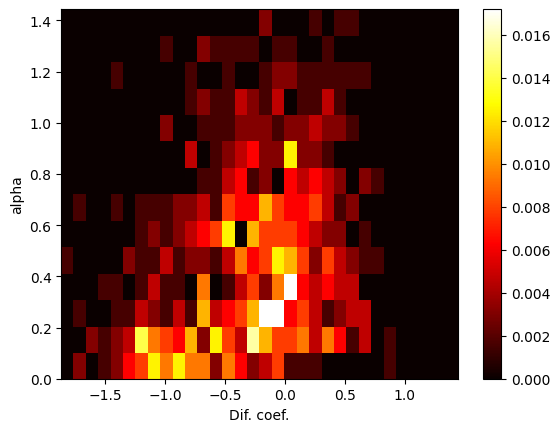

In [196]:
# Relationship diff. coef. and alpha
# Process data
data3 = seg_ds2
data4 = seg_alphas2

# Compute the 2D histogram
hist_2d_2, xedges, yedges = np.histogram2d(data4, data3, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_2)
hist_2d_normalized2 = hist_2d_2 / total_data_points

#Plot
plt.imshow(hist_2d_normalized2, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('auto')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
plt.ylim(0, data_range[1])
plt.colorbar()

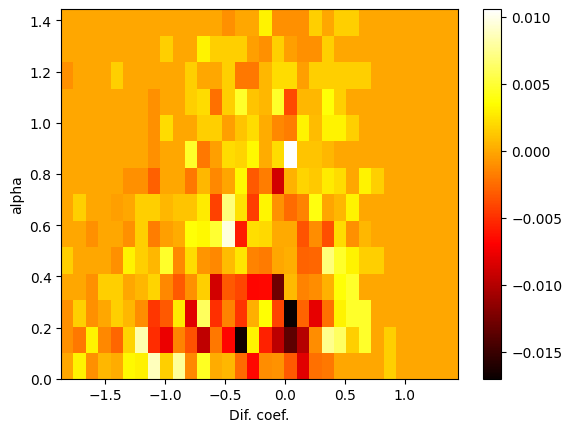

In [197]:
#Subtraction of the histograms
hist_2d_diff = hist_2d_normalized2 - hist_2d_normalized1

#Plot
plt.imshow(hist_2d_diff, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
plt.gca().set_aspect('auto')
plt.ylim(0, data_range[1])
plt.colorbar()

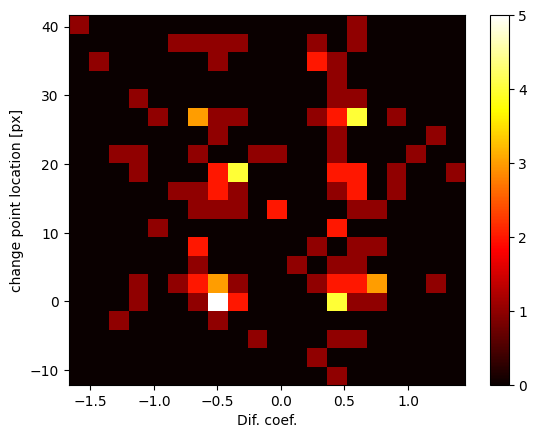

In [53]:
# Relationship diff. coef. change point and distance to MCS
# Process data
data1 = cps_location
data2 = jumps_dif

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(~np.isnan(data1))))
bin_size2 = int(np.sqrt(len(~np.isnan(data2))))
#chosen_bin_size = min(bin_size1, bin_size2)
chosen_bin_size = 20
bin_edges_x = np.linspace(np.nanmin(data2), np.nanmax(data2), chosen_bin_size + 1)
bin_edges_y = np.linspace(np.nanmin(data1), np.nanmax(data1), chosen_bin_size + 1)

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=[bin_edges_x, bin_edges_y])
hist_2d_1 = hist_2d_1.T

# Normalization by the number of points at each distance (all_close)
# Flatten all tensors in all_close and convert to a single NumPy array
all_close_flat = np.concatenate([c.numpy().flatten() for c in all_close])
counts, _ = np.histogram(all_close_flat, bins=bin_edges_y)
hist_2d_normalized1 = np.array([row / count if count > 0 else row for row, count in zip(hist_2d_1, counts)])

#Plot
plt.imshow(hist_2d_normalized1, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('Dif. coef.')
plt.ylabel('change point location [px]')
#plt.ylim(-10, 40)
plt.colorbar()
plt.gca().set_aspect('auto')
plt.show()

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  2.,  3.,  0.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  9.,  9.,  4.,  4.,  4.,  0.],
        [ 0.,  0.,  1.,  2., 11., 12., 21.,  2.,  7.,  4.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  3.,  1.,  2.,  0.],
        [ 0.,  0.,  1.,  1.,  8.,  6.,  9.,  2.,  5.,  2.],
        [ 0.,  0.,  0.,  5., 14., 15., 11.,  4.,  6.,  6.],
        [ 1.,  0.,  0.,  0.,  3.,  5.,  6.,  3.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  0.,  1.]]),
 array([-1.91083896, -1.57916251, -1.24748607, -0.91580962, -0.58413317,
        -0.25245672,  0.07921972,  0.41089617,  0.74257262,  1.07424906,
         1.40592551]),
 array([-44.52271385, -35.81671261, -27.11071137, -18.40471013,
         -9.69870889,  -0.99270765,   7.71329359,  16.41929483,
         25.12529607,  33.8312973 ,  42.53729854]),
 <matplotlib.collections.QuadMesh at 0x2c2147702e

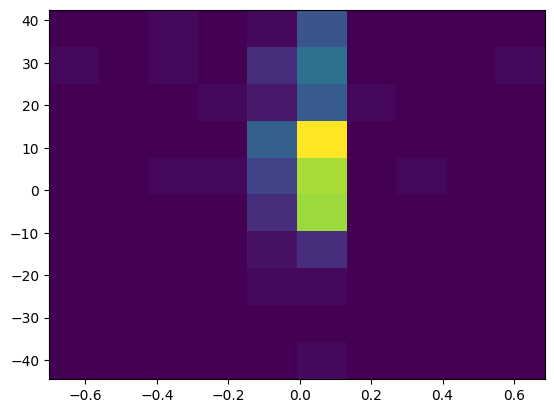

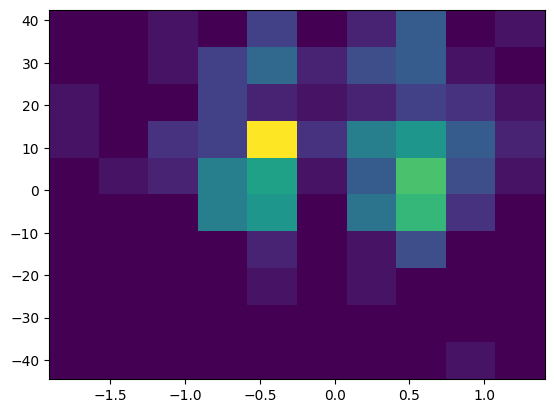

In [36]:
plt.figure()
plt.hist2d(jumps_alpha, cps_location)
plt.figure()
plt.hist2d(jumps_dif, cps_location)

In [63]:
# Relationship diff. coef. change point and distance to MCS
# Process data
data1 = cps_location
data2 = jumps_dif
all_close_flat = np.concatenate([c.detach().numpy().flatten() for c in all_close])
# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(~np.isnan(data1))))
bin_size2 = int(np.sqrt(len(~np.isnan(data2))))
chosen_bin_size = min(bin_size1, bin_size2)
bin_edges_x = np.linspace(np.nanmin(data2), np.nanmax(data2), chosen_bin_size + 1)
bin_edges_y = np.linspace(np.nanmin(data1), np.nanmax(data1), chosen_bin_size + 1)

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=[bin_edges_x, bin_edges_y])

y_counts = np.zeros_like(yedges[:-1])  # Exclude the last edge since it's not a bin start
for i in range(len(yedges)-1):
    # Count how many values fall into each y-bin
    y_counts[i] = np.sum((all_close >= yedges[i]) & (all_close < yedges[i+1]))

# Normalize each row of the histogram by the number of counts in all_close for that y-bin
normalized_hist = np.zeros_like(hist_2d)
for i in range(len(y_counts)):
    if y_counts[i] > 0:  # Avoid division by zero
        normalized_hist[i, :] = hist_2d[i, :] / y_counts[i]
#Plot
plt.imshow(normalized_hist, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('Dif. coef.')
plt.ylabel('change point location [px]')
#plt.ylim(-20, 40)
plt.colorbar()
plt.gca().set_aspect('auto')
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (686,) + inhomogeneous part.

In [50]:
## Ridge plot for D vs. changepoint location

# Select data
data1 = cps_location
data2 = jumps_alpha

# Classify the predictions into groups
def classify_predictions(predictions):
    bins = [-4, -0.5, 0.5, 2]  # The edges of the bins for classification
    group_labels = ['decrease', 'same', 'increase']
    group_indices = np.digitize(predictions, bins) - 1  # Get bin indices
    groups = [group_labels[i] if i < len(group_labels) else 'Unknown' for i in group_indices]
    return groups

# Assign each close1 value to a group based on pred_d
groups = classify_predictions(data2)

# Create the DataFrame
df = pd.DataFrame({
    'Value': data1,
    'Group': groups
})
df['Group'] = pd.Categorical(df['Group'], categories=['decrease', 'same', 'increase'], ordered=True)

In [51]:
from scipy.stats import gaussian_kde
import seaborn as sns

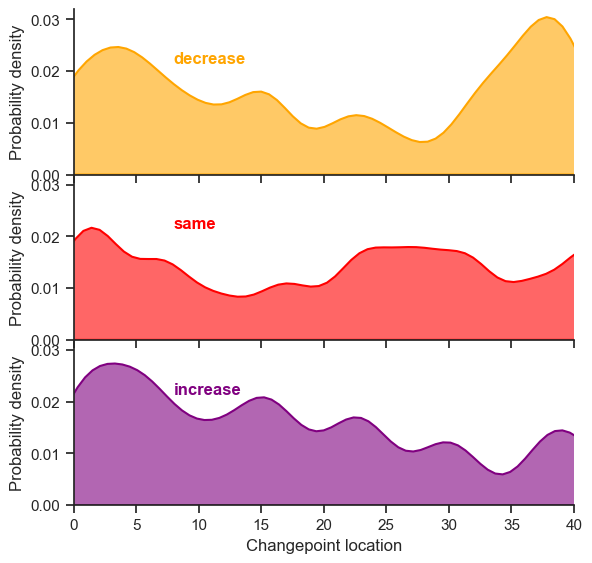

In [52]:
# Set up the matplotlib figure
custom_palette = {
    'decrease': 'orange', 
    'same': 'red',    
    'increase': 'purple'  
}
sns.set(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the FacetGrid. 'row' should be the name of the DataFrame column that contains the group names.
g = sns.FacetGrid(df, row='Group', hue='Group', aspect=3, height=2,
                  palette=custom_palette)

# Binning
total_data_points = len(df['Value'])  # Total number of data points across all groups
num_bins = int(np.sqrt(total_data_points))

g.map(sns.kdeplot, 'Value', clip_on=True, fill=True, alpha=0.6, lw=1.5, bw_adjust=0.2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.2, .7, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axis titles and ticks
g.set_titles("")
g.set_xlabels('Changepoint location')
g.set_ylabels('Probability density')

# Despine and show the plot
g.despine(bottom=False, left=False)  # Keep the left spine for the y-axis

# x-axis limits
for ax in g.axes.flat:
    ax.set_xlim(0, 40)
    
plt.show()

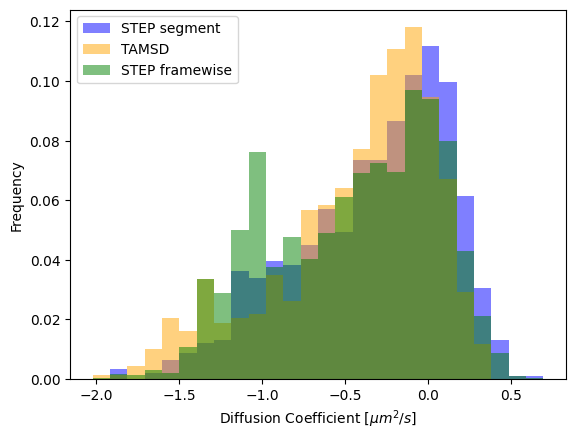

In [33]:
#Representation of Dif Coef of one dataset vs. TAMSD whole traj. 
data1 = np.array(seg_ds)
data2 = np.array(tamsd_dif)
data3 = torch.cat(pred_d).numpy()
#Determine number of bins
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
counts3, _ = np.histogram(data3, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
relative_probs3 = counts3 / counts3.sum()
# Plot the histograms
width = np.diff(bin_edges)
plt.bar(bin_edges[:-1], relative_probs1, width=width, alpha=0.5, color='blue', label='STEP segment', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=width, alpha=0.5, color='orange', label='TAMSD', align='edge')
plt.bar(bin_edges[:-1], relative_probs3, width=width, alpha=0.5, color='green', label='STEP framewise', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()